In [1]:
# Standard Library Imports
import os
import re
import json
import random
import multiprocessing
from typing import Any, Tuple, Optional, List, Dict
from functools import partial
import glob
import shutil
import pickle
from datetime import datetime
import time
from collections import deque
# Third-party Imports
import numpy as np
import pandas as pd
import cirq
import cirq_google
import qsimcirq
import matplotlib.pyplot as plt
from IPython.display import display
import logging
from deap import creator, base, tools

import grape  # Grammatical evolution library
from grape import algorithms  # Evolutionary algorithms

In [2]:
logger = logging.getLogger(__name__)

In [3]:
# Transfer Learning Configuration
USE_TRANSFER_LEARNING = True  # Toggle for transfer learning
SOURCE_CHECKPOINT = "checkpoints_google_noise_rainbow/checkpoint_latest.pkl"  # Path to source checkpoint (Google noise → Cirq for 001 state)
TRANSFER_RATIO = 0.3  # Use 30% of population from previous evolution
MUTATION_BOOST = 0.3  # Additional 30% are mutated versions of transferred individuals

# Alternative source options:
# SOURCE_CHECKPOINT = "checkpoints_ideal/checkpoint_latest.pkl"  # IBM ideal → Cirq
# SOURCE_CHECKPOINT = "checkpoints_noise_110/checkpoint_latest.pkl"  # IBM noise → Cirq
# SOURCE_CHECKPOINT = "checkpoints_google_ideal/checkpoint_latest.pkl"  # Cirq ideal → Cirq

In [4]:
# Resume Configuration
RESUME_FROM_CHECKPOINT = False  # Set to True to resume from latest checkpoint, False for fresh start

In [5]:
USE_FIXED_SEED = True  # Set to False for random initialization, Set to True for fixed seed
USE_NOISE_MODEL = True  # Set to True for Google QVM with transpilation, False for ideal simulation

# Google Quantum Virtual Machine Configuration
GOOGLE_PROCESSOR = "rainbow"  # Options: "rainbow", "weber", "willow_pink"

if USE_FIXED_SEED:
    RANDOM_SEED = 79251
    print(f"Using fixed seed: {RANDOM_SEED}")
else:
    RANDOM_SEED = int(time.time()) % 100000
    print(f"Using random seed: {RANDOM_SEED}")
    # Save the seed so you can reproduce good runs
    with open('cirq_last_random_seed.txt', 'w') as f:
        f.write(str(RANDOM_SEED))

# Display simulation mode
if USE_NOISE_MODEL:
    print("NOISE MODEL: ENABLED - Using Google QVM with transpilation (realistic but slower)")
    print(f"  Processor: {GOOGLE_PROCESSOR}")
    print("  Circuits will be transpiled during evolution for hardware constraints")
else:
    print("NOISE MODEL: DISABLED - Using ideal simulation (faster for exploration)")
    print("  No transpilation during evolution")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Using fixed seed: 79251
NOISE MODEL: ENABLED - Using Google QVM with transpilation (realistic but slower)
  Processor: rainbow
  Circuits will be transpiled during evolution for hardware constraints


In [6]:
# Get the number of logical CPU cores available
num_cores = os.cpu_count()
print("Number of CPU cores available:", num_cores)

# Initialize simulators based on noise model preference (like IBM notebook)
if USE_NOISE_MODEL:
    print(f"\nSetting up Google QVM simulation mode")
    
    try:
        # Create Google QVM simulator (noise is handled automatically by qsimcirq)
        google_qvm_sim = qsimcirq.QSimSimulator(seed=RANDOM_SEED)
        
        # Also create ideal simulator for comparison
        ideal_sim = cirq.Simulator(seed=RANDOM_SEED)
        
        # Use standard qubits - transpilation will handle device constraints
        device_qubits = [cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2)]
        device = None  # Transpilation handles device constraints
        
        print("✓ Google QVM simulation mode enabled")
        print(f"  QVM simulator ready (noise handled automatically)")
        print(f"  Transpilation will occur during fitness evaluation")
        print(f"  Target processor: {GOOGLE_PROCESSOR}")
        print("  Ideal simulator also available for comparison")
        
    except Exception as e:
        print(f"⚠ Warning: Could not set up Google QVM: {e}")
        print("Falling back to ideal simulation for both modes")
        USE_NOISE_MODEL = False
        google_qvm_sim = cirq.Simulator(seed=RANDOM_SEED)
        ideal_sim = google_qvm_sim
        device_qubits = [cirq.GridQubit(0, i) for i in range(3)]
        device = None
        
else:
    print("\nUsing ideal simulation for both modes")
    ideal_sim = cirq.Simulator(seed=RANDOM_SEED)
    google_qvm_sim = ideal_sim  # Point to same ideal simulator
    device_qubits = [cirq.GridQubit(0, i) for i in range(3)]  # Simple grid qubits
    device = None

Number of CPU cores available: 8

Setting up Google QVM simulation mode
✓ Google QVM simulation mode enabled
  QVM simulator ready (noise handled automatically)
  Transpilation will occur during fitness evaluation
  Target processor: rainbow
  Ideal simulator also available for comparison


In [7]:
# %% 
# Early Stopping Configuration - NISQ Focused
USE_EARLY_STOPPING = True  # Set to False to disable early stopping completely

# Early stopping mode: "aggressive", "conservative", "balanced", or "nisq_focused"
EARLY_STOPPING_MODE = "nisq_focused"  # NISQ-era hardware optimization focus

# Minimum generations before early stopping can trigger
MIN_GENERATIONS_BEFORE_STOPPING = 15  # Don't stop before this many generations

# NISQ-specific thresholds
FIDELITY_SUCCESS_THRESHOLD = 0.95  # Consider "good enough" for NISQ devices
GATE_COUNT_TARGET = 20  # Ideal target for gate count
DEPTH_TARGET = 15  # Ideal target for circuit depth

# Configure based on mode
if EARLY_STOPPING_MODE == "nisq_focused":
    # NISQ-era focused: Prioritize fidelity first, then hardware efficiency
    EARLY_STOPPING_PATIENCE = {
        'fitness': 25,        # Least important - just a backup
        'fidelity': 8,        # Stop quickly once fidelity is achieved
        'gate_count': 10,     # Main focus after fidelity
        'depth': 10,          # Critical for decoherence
        'composite': 15       # Overall backup
    }
    MIN_IMPROVEMENT_DELTA = {
        'fitness': 0.01,      
        'fidelity': 0.005,    # 0.5% improvement in fidelity
        'gate_count': 1,      # Every gate counts on NISQ
        'depth': 1            # Every layer matters for decoherence
    }
    # NISQ-optimized weights
    METRIC_WEIGHTS = {
        'fitness': 0.15,      # De-emphasize combined fitness
        'fidelity': 0.35,     # Most important initially
        'gate_count': 0.30,   # Critical for error rates
        'depth': 0.20         # Critical for decoherence time
    }
    EARLY_STOPPING_STRATEGY = "nisq_hierarchical"  # Special NISQ strategy
    
elif EARLY_STOPPING_MODE == "aggressive":
    # Original aggressive settings for comparison
    EARLY_STOPPING_PATIENCE = {
        'fitness': 5,
        'fidelity': 7,
        'gate_count': 8,
        'composite': 5
    }
    MIN_IMPROVEMENT_DELTA = {
        'fitness': 0.01,
        'fidelity': 0.02,
        'gate_count': 2,
        'depth': 1
    }
    METRIC_WEIGHTS = {
        'fitness': 0.4,
        'fidelity': 0.3,
        'gate_count': 0.2,
        'depth': 0.1
    }
    EARLY_STOPPING_STRATEGY = "any"
    
elif EARLY_STOPPING_MODE == "conservative":
    # Original conservative settings
    EARLY_STOPPING_PATIENCE = {
        'fitness': 15,
        'fidelity': 20,
        'gate_count': 20,
        'composite': 15
    }
    MIN_IMPROVEMENT_DELTA = {
        'fitness': 0.001,
        'fidelity': 0.005,
        'gate_count': 1,
        'depth': 1
    }
    METRIC_WEIGHTS = {
        'fitness': 0.5,
        'fidelity': 0.25,
        'gate_count': 0.15,
        'depth': 0.1
    }
    EARLY_STOPPING_STRATEGY = "any"
    
else:  # balanced (default)
    EARLY_STOPPING_PATIENCE = {
        'fitness': 10,
        'fidelity': 12,
        'gate_count': 15,
        'composite': 10
    }
    MIN_IMPROVEMENT_DELTA = {
        'fitness': 0.005,
        'fidelity': 0.01,
        'gate_count': 1,
        'depth': 1
    }
    METRIC_WEIGHTS = {
        'fitness': 0.45,
        'fidelity': 0.30,
        'gate_count': 0.15,
        'depth': 0.1
    }
    EARLY_STOPPING_STRATEGY = "any"

# Moving average window for smoothing noisy metrics
MOVING_AVERAGE_WINDOW = 3  # Use average of last N generations

# Whether to use relative or absolute improvement
USE_RELATIVE_IMPROVEMENT = True  # If True, use percentage improvement

# Verbose logging for early stopping decisions
EARLY_STOPPING_VERBOSE = True  # Print detailed info

# Display configuration summary
if USE_EARLY_STOPPING:
    print(f"\n{'='*60}")
    print("EARLY STOPPING CONFIGURATION")
    print(f"{'='*60}")
    print(f"Mode: {EARLY_STOPPING_MODE}")
    print(f"Strategy: {EARLY_STOPPING_STRATEGY}")
    print(f"Min generations before stopping: {MIN_GENERATIONS_BEFORE_STOPPING}")
    print(f"Moving average window: {MOVING_AVERAGE_WINDOW}")
    print(f"Use relative improvement: {USE_RELATIVE_IMPROVEMENT}")
    
    if EARLY_STOPPING_MODE == "nisq_focused":
        print(f"\n NISQ-Specific Targets:")
        print(f"  Fidelity success threshold: {FIDELITY_SUCCESS_THRESHOLD}")
        print(f"  Gate count target: ≤{GATE_COUNT_TARGET}")
        print(f"  Depth target: ≤{DEPTH_TARGET}")
        print(f"\n Strategy: Hierarchical NISQ optimization")
        print(f"  Phase 1: Achieve fidelity ≥{FIDELITY_SUCCESS_THRESHOLD}")
        print(f"  Phase 2: Optimize gates & depth until stagnation")
        print(f"  Phase 3: Stop when hardware metrics cannot improve further")
    
    print(f"\nPatience values:")
    for metric, patience in EARLY_STOPPING_PATIENCE.items():
        print(f"  {metric}: {patience} generations")
    
    print(f"\nMinimum improvement thresholds:")
    for metric, delta in MIN_IMPROVEMENT_DELTA.items():
        if metric in ['fitness', 'fidelity'] and USE_RELATIVE_IMPROVEMENT:
            print(f"  {metric}: {delta*100:.2f}%")
        else:
            print(f"  {metric}: {delta}")
    
    print(f"\nComposite score weights:")
    for metric, weight in METRIC_WEIGHTS.items():
        print(f"  {metric}: {weight:.2f}")
    
    print(f"{'='*60}")
else:
    print("\nEarly stopping: DISABLED")


EARLY STOPPING CONFIGURATION
Mode: nisq_focused
Strategy: nisq_hierarchical
Min generations before stopping: 15
Moving average window: 3
Use relative improvement: True

 NISQ-Specific Targets:
  Fidelity success threshold: 0.95
  Gate count target: ≤20
  Depth target: ≤15

 Strategy: Hierarchical NISQ optimization
  Phase 1: Achieve fidelity ≥0.95
  Phase 2: Optimize gates & depth until stagnation
  Phase 3: Stop when hardware metrics cannot improve further

Patience values:
  fitness: 25 generations
  fidelity: 8 generations
  gate_count: 10 generations
  depth: 10 generations
  composite: 15 generations

Minimum improvement thresholds:
  fitness: 1.00%
  fidelity: 0.50%
  gate_count: 1
  depth: 1

Composite score weights:
  fitness: 0.15
  fidelity: 0.35
  gate_count: 0.30
  depth: 0.20


In [8]:
BNF_GRAMMAR = grape.Grammar("grammars/cirq_grover.bnf")

In [9]:
# Define evaluation constants
NUM_SHOTS = 10000
SUCCESS_THRESHOLD = 0.48
GATE_PENALTY_WEIGHT = 0.02
TARGET_STATE = "011"  # Target state for Grover's algorithm

In [10]:
# Set directories based on noise model configuration (like IBM notebook)
if USE_NOISE_MODEL:
    LOG_DIR = f"logs_marked_state_GOOGLE_{GOOGLE_PROCESSOR}_{TARGET_STATE}_10000_noise"
    CHECKPOINT_DIR = f"checkpoints_google_noise_{TARGET_STATE}_{GOOGLE_PROCESSOR}"
else:
    LOG_DIR = f"logs_marked_state_GOOGLE_{TARGET_STATE}_10000_ideal"
    CHECKPOINT_DIR = f"checkpoints_google_ideal_{TARGET_STATE}"

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Logs will be saved to: {LOG_DIR}")
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")

Logs will be saved to: logs_marked_state_GOOGLE_rainbow_011_10000_noise
Checkpoints will be saved to: checkpoints_google_noise_011_rainbow


In [11]:
# Checkpoint configuration
CHECKPOINT_FREQUENCY = 10  # Save every N generations

In [12]:
def plot_distribution_cirq(counts, title=""):
    """Plot distribution for Cirq results."""
    if not counts:
        return None
    
    keys = list(counts.keys())
    values = list(counts.values())
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(keys, values)
    ax.set_xlabel('Bitstring')
    ax.set_ylabel('Counts')
    ax.set_title(title)
    plt.xticks(rotation=45)
    return fig

In [13]:
def generate_oracle_for_state_cirq(marked_state: str) -> str:
    """Generate Grover oracle code for Cirq for a given marked state."""
    n = len(marked_state)
    code_lines = []
    
    # For each qubit where the marked state is '0', apply X gate
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"circuit.append(cirq.X(qubits[{i}]))")
    
    # Apply multi-controlled Z gate (phase flip)
    if n == 3:
        # For 3 qubits, use CCZ
        code_lines.append(f"circuit.append(cirq.CCZ(qubits[0], qubits[1], qubits[2]))")
    else:
        # For general case, would need to construct multi-controlled Z
        # This is a simplified version for 3 qubits
        code_lines.append(f"circuit.append(cirq.H(qubits[{n-1}]))")
        if n == 2:
            code_lines.append(f"circuit.append(cirq.CNOT(qubits[0], qubits[1]))")
        else:
            code_lines.append(f"circuit.append(cirq.CCX(qubits[0], qubits[1], qubits[2]))")
        code_lines.append(f"circuit.append(cirq.H(qubits[{n-1}]))")
    
    # Undo the X gates
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"circuit.append(cirq.X(qubits[{i}]))")
    
    return "\n".join(code_lines) + "\n"

In [14]:
class CircuitEvaluator:
    def __init__(self, shots: int = NUM_SHOTS, log_dir: str = LOG_DIR, 
                 seed: int = None, use_noise: bool = USE_NOISE_MODEL):
        """
        Initialize the evaluator with simulation parameters and logging directory.
        Matches IBM notebook approach with dual simulator setup.
        """
        self.shots = shots
        self.log_dir = log_dir
        self.seed = seed if seed is not None else RANDOM_SEED
        self.use_noise = use_noise
        os.makedirs(self.log_dir, exist_ok=True)

    def decode_individual(self, ind) -> Optional[str]:
        """
        Robust decoder for phenotype -> cleaned Python source string.
        """
        if not hasattr(ind, 'phenotype') or getattr(ind, 'invalid', False):
            return None

        try:
            if isinstance(ind.phenotype, list):
                code = ''.join(ind.phenotype)
            else:
                code = ind.phenotype or ''

            if not isinstance(code, str):
                return None

            code = code.replace('\\n', '\n')
            code = code.replace('"', '')
            code = '\n'.join(re.sub(r'[ \t]+', ' ', ln) for ln in code.splitlines())
            code = re.sub(r'qubits\[\s*(\d+)\s*\]', r'qubits[\1]', code)
            code = re.sub(r'(qubits\[\d+\])\s*(?=qubits\[\d+\])', r'\1, ', code)
            code = re.sub(r',\s*qubits', r', qubits', code)

            def _exp_before_call_repl(m):
                gate = m.group(1)
                exponent = m.group(2)
                qindex = m.group(3)
                return f'({gate}**{exponent}).on(qubits[{qindex}])'

            code = re.sub(
                r'(\bcirq\.[A-Za-z_][A-Za-z0-9_\.]*)\s*\*\*\s*([-]?\d+(?:\.\d+)?)\s*\(\s*qubits\[\s*(\d+)\s*\]\s*\)',
                _exp_before_call_repl,
                code
            )

            code = re.sub(r'\)\s*\*\*\s*([0-9]+(?:\.[0-9]+)?)', r')**\1', code)
            lines = [ln.rstrip() for ln in code.splitlines()]
            code = '\n'.join(ln.lstrip() for ln in lines)

            def balanced_parens(s: str) -> bool:
                stack = []
                pairs = {'(': ')', '[': ']', '{': '}'}
                for ch in s:
                    if ch in pairs:
                        stack.append(pairs[ch])
                    elif ch in pairs.values():
                        if not stack or ch != stack.pop():
                            return False
                return not stack

            if '"' in code or not balanced_parens(code):
                return None

            if re.search(r'circuit\.append\s*\(\s*[A-Za-z_\.]*\s*$', code) or code.rstrip().endswith('\\'):
                return None

            if not code.strip():
                return None

            return code
        except Exception:
            return None
        
    def execute_circuit(self, phenotype_code: str) -> cirq.Circuit:
        """
        Executes phenotype code. Uses Google device qubits when noise model is enabled.
        """
        # Use appropriate qubits based on noise model setting
        if self.use_noise and 'device_qubits' in globals() and device_qubits:
            setup_code = f"qubits = {device_qubits}\n"
        else:
            setup_code = "qubits = [cirq.LineQubit(i) for i in range(3)]\n"
            
        full_code = setup_code + phenotype_code
        local_vars = {}
        
        try:
            exec(full_code, globals(), local_vars)
            if "circuit" in local_vars:
                return local_vars["circuit"]
            else:
                return None
        except Exception:
            return None
        
    def simulate_circuit(self, circuit: cirq.Circuit, marked_state: str, 
                        individual_seed: int = None) -> dict:
        """
        Simulates circuit using either Google QVM with transpilation or ideal simulation.
        """
        sim_seed = individual_seed if individual_seed is not None else self.seed

        try:
            if self.use_noise:
                # Use Google QVM with transpilation (same as run_hof_on_google_hardware)
                simulator = google_qvm_sim
                sim_type = f"google_qvm_{GOOGLE_PROCESSOR}"
                
                try:
                    # Transpile circuit for Google hardware (same as in run_hof_on_google_hardware)
                    import warnings
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_repetition_ids.*")
                        
                        # Use cirq.optimize_for_target_gateset with SycamoreTargetGateset
                        # This is Google's equivalent to IBM's transpile() function
                        transpiled_circuit = cirq.optimize_for_target_gateset(
                            circuit, 
                            gateset=cirq_google.SycamoreTargetGateset()
                        )
                    
                    circuit = transpiled_circuit
                    
                except Exception as transpile_error:
                    # If transpilation fails, return error (like IBM approach)
                    return {
                        "counts": {},
                        "p_marked": 0.0,
                        "error": 1.0,
                        "gate_count": 999,
                        "depth": 999,
                        "sim_type": "transpile_error"
                    }
                        
            else:
                # Use ideal simulation (no transpilation)
                simulator = ideal_sim
                sim_type = "ideal"
                
            # Run simulation
            result = simulator.run(circuit, repetitions=self.shots)
            
            # Process measurements - FIXED VERSION
            counts = {}
            if hasattr(result, 'measurements'):
                measurement_keys = list(result.measurements.keys())
                
                # Process each shot (repetition) individually to avoid triple-counting
                for shot_idx in range(self.shots):
                    bitstring = ""
                    
                    # For each qubit measurement key, get the bit for this shot
                    for key in sorted(measurement_keys):  # Sort to ensure consistent bit order
                        measurements = result.measurements[key]
                        if shot_idx < len(measurements):
                            bit_value = measurements[shot_idx]
                            if isinstance(bit_value, (list, tuple, np.ndarray)):
                                # If it's an array, take the first element
                                bit_value = bit_value[0] if len(bit_value) > 0 else 0
                            bitstring += str(int(bit_value))
                    
                    # Ensure we have exactly 3 bits for our target state
                    if len(bitstring) == 3:
                        counts[bitstring] = counts.get(bitstring, 0) + 1
                    elif len(bitstring) > 3:
                        bitstring = bitstring[:3]
                        counts[bitstring] = counts.get(bitstring, 0) + 1
                    elif len(bitstring) < 3:
                        bitstring = bitstring.zfill(3)
                        counts[bitstring] = counts.get(bitstring, 0) + 1
            
            # Calculate probability of marked state
            total = sum(counts.values())
            p_marked = counts.get(marked_state, 0) / total if total > 0 else 0.0
            error = 1 - p_marked
            
            # Count gates and depth (from final circuit)
            gate_count = len(list(circuit.all_operations()))
            depth = len(circuit.moments)
            
            return {
                "counts": counts,
                "p_marked": p_marked,
                "error": error,
                "gate_count": gate_count,
                "depth": depth,
                "sim_type": sim_type
            }
            
        except Exception as e:
            return {
                "counts": {},
                "p_marked": 0.0,
                "error": 1.0,
                "gate_count": 999,
                "depth": 999,
                "sim_type": "error"
            }
    
    def log_evaluation(self, logs: list, generation: int, individual) -> None:
        """
        Logs the evaluation details for an individual to JSON and CSV files.
        """
        if not logs:
            return
            
        id_hash = hash(str(individual.genome)) % 10**8
        log_file_json = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.json")
        log_file_csv = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.csv")
        
        # Add noise model status to logs (like IBM notebook)
        for log_entry in logs:
            log_entry['noise_model_used'] = self.use_noise
            if self.use_noise:
                log_entry['processor'] = GOOGLE_PROCESSOR
            
        with open(log_file_json, "w") as f:
            json.dump(logs, f, indent=2)
        
        if logs and all(key in logs[0] for key in ["state", "p_marked", "error", "gate_count", "depth"]):
            df = pd.DataFrame(logs)
            df[["state", "p_marked", "error", "gate_count", "depth", "noise_model_used"]].to_csv(log_file_csv, index=False)

In [15]:
def inject_oracle_cirq(phenotype_str: str, oracle_code: str) -> str:
    """Inject oracle code into the Cirq phenotype string."""
    # print(f"DEBUG - Original phenotype:\n{repr(phenotype_str[:200])}...")
    
    # Handle fragmented string case - join all parts first
    if isinstance(phenotype_str, list):
        phenotype_str = ''.join(phenotype_str)
    elif not isinstance(phenotype_str, str):
        phenotype_str = str(phenotype_str)
    
    # Clean up the string - remove quote artifacts and fix formatting
    phenotype_str = phenotype_str.replace('"', '')
    
    # More robust pattern matching for oracle block
    # This handles cases where the oracle content might be fragmented
    pattern = r'## Begin Oracle\s*\n(.*?)## End Oracle\s*\n'
    
    if re.search(pattern, phenotype_str, flags=re.DOTALL):
        result = re.sub(pattern, f'## Begin Oracle\n{oracle_code}## End Oracle\n', 
                       phenotype_str, flags=re.DOTALL)
        # print(f"DEBUG - Oracle injection successful")
        # print(f"DEBUG - Injected oracle:\n{oracle_code}")
    else:
        # print(f"DEBUG - Oracle markers not found, phenotype:")
        # print(f"{phenotype_str}")
        result = phenotype_str
    
    return result

In [16]:
# %%
def fitness_function_cirq(
    phenotype_str,
    shots=NUM_SHOTS,
    threshold=SUCCESS_THRESHOLD,
    gate_penalty_weight=GATE_PENALTY_WEIGHT,
    target_state=TARGET_STATE,
    log_states=True,
    individual_seed=None,
    use_noise=USE_NOISE_MODEL,
    return_metrics=False,  # New parameter for returning detailed metrics
):
    """
    Fitness function adapted for Cirq circuits with Google QVM.
    Now optionally returns detailed metrics for early stopping.
    """
    if not isinstance(phenotype_str, str):
        if return_metrics:
            return {
                'fitness': float('inf'),
                'fidelity': 0.0,
                'gate_count': 999,
                'depth': 999,
                'error': 1.0,
                'logs': []
            }
        return (float('inf'), []) if log_states else float('inf')
    
    evaluator = CircuitEvaluator(shots=shots, seed=individual_seed, use_noise=use_noise)
    logs = []
    
    # Generate and inject oracle
    oracle_code = generate_oracle_for_state_cirq(target_state)
    modified_code = inject_oracle_cirq(phenotype_str, oracle_code)
    
    # Execute circuit
    circuit = evaluator.execute_circuit(modified_code)
    if circuit is None:
        if return_metrics:
            return {
                'fitness': float('inf'),
                'fidelity': 0.0,
                'gate_count': 999,
                'depth': 999,
                'error': 1.0,
                'logs': []
            }
        return (float('inf'), []) if log_states else float('inf')
    
    # Simulate (with transpilation if using noise model)
    result = evaluator.simulate_circuit(
        circuit,
        target_state,
        individual_seed=individual_seed,
    )
    
    p_marked = result["p_marked"]
    error = 1 - p_marked
    miss = 1 if error > threshold else 0
    gate_count = result.get("gate_count", 0)
    depth = result.get("depth", 0)
    
    # Calculate fitness
    fitness_score = 10 * miss + error + gate_penalty_weight * gate_count
    
    if log_states:
        logs.append({
            "state": target_state,
            "p_marked": p_marked,
            "error": error,
            "gate_count": gate_count,
            "depth": depth,
            "oracle": oracle_code,
            "code": modified_code,
            "counts": result["counts"],
            "sim_type": result.get("sim_type", "unknown"),
        })
    
    # Return based on what's requested
    if return_metrics:
        return {
            'fitness': fitness_score,
            'fidelity': p_marked,
            'gate_count': gate_count,
            'depth': depth,
            'error': error,
            'miss': miss,
            'logs': logs
        }
    elif log_states:
        return (fitness_score, logs)
    else:
        return fitness_score

print("✓ Fitness function updated with metrics support")

✓ Fitness function updated with metrics support


In [17]:
# %%
def save_checkpoint(population, generation, hof, best_fitness_list, avg_gate_count_list, 
                   generations_list, checkpoint_dir=CHECKPOINT_DIR, early_stopping_monitor=None):
    """Save checkpoint of current evolution state with early stopping support."""
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_gen_{generation}.pkl")
    checkpoint_data = {
        'population': population,
        'generation': generation,
        'hof': hof,
        'best_fitness_list': best_fitness_list,
        'avg_gate_count_list': avg_gate_count_list,
        'generations_list': generations_list,
        'random_state': random.getstate(),
        'numpy_state': np.random.get_state(),
        'timestamp': datetime.now().isoformat(),
        'random_seed': RANDOM_SEED,
        'noise_model_used': USE_NOISE_MODEL,
        'google_processor': GOOGLE_PROCESSOR if USE_NOISE_MODEL else None,
        # Early stopping state
        'early_stopping_enabled': USE_EARLY_STOPPING,
        'early_stopping_state': early_stopping_monitor.get_state() if early_stopping_monitor else None
    }
    
    try:
        with open(checkpoint_path, 'wb') as f:
            pickle.dump(checkpoint_data, f)
        print(f"✓ Checkpoint saved: {checkpoint_path}")
        
        # Also save as latest
        latest_path = os.path.join(checkpoint_dir, "checkpoint_latest.pkl")
        with open(latest_path, 'wb') as f:
            pickle.dump(checkpoint_data, f)
            
        # If early stopping triggered, save special checkpoint
        if early_stopping_monitor and early_stopping_monitor.stop_triggered:
            early_stop_path = os.path.join(checkpoint_dir, f"checkpoint_early_stop_gen_{generation}.pkl")
            with open(early_stop_path, 'wb') as f:
                pickle.dump(checkpoint_data, f)
            print(f"✓ Early stop checkpoint saved: {early_stop_path}")
            
    except Exception as e:
        print(f"Warning: Could not save checkpoint: {e}")

def load_checkpoint(checkpoint_path):
    """Load checkpoint from file with early stopping support."""
    try:
        with open(checkpoint_path, 'rb') as f:
            checkpoint_data = pickle.load(f)
        
        random.setstate(checkpoint_data['random_state'])
        np.random.set_state(checkpoint_data['numpy_state'])
        
        print(f"✓ Checkpoint loaded from generation {checkpoint_data['generation']}")
        print(f"  Timestamp: {checkpoint_data['timestamp']}")
        
        # Check noise model compatibility
        if 'noise_model_used' in checkpoint_data:
            if checkpoint_data['noise_model_used'] != USE_NOISE_MODEL:
                print(f"  WARNING: Checkpoint was created with noise_model={checkpoint_data['noise_model_used']}")
                print(f"  Current setting is noise_model={USE_NOISE_MODEL}")
        
        if 'google_processor' in checkpoint_data and checkpoint_data['google_processor']:
            print(f"  Google processor from checkpoint: {checkpoint_data['google_processor']}")
            if checkpoint_data['google_processor'] != GOOGLE_PROCESSOR:
                print(f"  Current processor setting: {GOOGLE_PROCESSOR}")
        
        # Check early stopping compatibility
        if 'early_stopping_enabled' in checkpoint_data:
            checkpoint_es = checkpoint_data['early_stopping_enabled']
            if checkpoint_es != USE_EARLY_STOPPING:
                print(f"  WARNING: Checkpoint early stopping was {checkpoint_es}")
                print(f"  Current setting is {USE_EARLY_STOPPING}")
            
            if checkpoint_es and USE_EARLY_STOPPING and checkpoint_data.get('early_stopping_state'):
                print(f"  Early stopping state will be restored")
        
        return checkpoint_data
    except Exception as e:
        print(f"Could not load checkpoint: {e}")
        return None

print("✓ Checkpoint functions updated with early stopping support")

✓ Checkpoint functions updated with early stopping support


In [ ]:
class EarlyStoppingMonitor:
    """
    Monitors multiple metrics during evolution and determines when to stop.
    Enhanced with NISQ-focused hierarchical stopping strategy.
    """
    
    def __init__(self, 
                 patience_dict: Dict[str, int],
                 min_delta_dict: Dict[str, float],
                 weights_dict: Dict[str, float],
                 strategy: str = "any",
                 window_size: int = 3,
                 use_relative: bool = True,
                 min_generations: int = 10,
                 verbose: bool = True):
        """
        Initialize the early stopping monitor with NISQ enhancements.
        """
        self.patience = patience_dict
        self.min_delta = min_delta_dict
        self.weights = weights_dict
        self.strategy = strategy
        self.window_size = window_size
        self.use_relative = use_relative
        self.min_generations = min_generations
        self.verbose = verbose
        
        # Initialize tracking structures
        self.history = {
            'fitness': deque(maxlen=100),
            'fidelity': deque(maxlen=100),
            'gate_count': deque(maxlen=100),
            'depth': deque(maxlen=100),
            'composite': deque(maxlen=100)
        }
        
        self.best_values = {
            'fitness': float('inf'),      # Lower is better
            'fidelity': 0.0,              # Higher is better
            'gate_count': float('inf'),   # Lower is better
            'depth': float('inf'),        # Lower is better
            'composite': float('inf')      # Lower is better
        }
        
        self.patience_counters = {
            'fitness': 0,
            'fidelity': 0,
            'gate_count': 0,
            'depth': 0,
            'composite': 0
        }
        
        self.generations_since_improvement = {
            'fitness': 0,
            'fidelity': 0,
            'gate_count': 0,
            'depth': 0,
            'composite': 0
        }
        
        # NISQ-specific tracking
        self.fidelity_achieved_generation = None
        self.phase = "fidelity_search"  # "fidelity_search" or "hardware_optimization"
        
        self.current_generation = 0
        self.stop_triggered = False
        self.stop_reason = None
        self.metrics_at_stop = None
        
    def calculate_composite_score(self, metrics: Dict[str, float]) -> float:
        """
        Calculate weighted composite score with NISQ focus.
        Lower is better for composite score.
        """
        # Normalize metrics for fair weighting
        normalized = {}
        
        # Fitness: already in good range
        normalized['fitness'] = max(0, metrics.get('fitness', float('inf')))
        
        # Fidelity: invert since higher is better
        normalized['fidelity'] = 1.0 - metrics.get('fidelity', 0.0)
        
        # Gate count: normalize by typical range
        normalized['gate_count'] = metrics.get('gate_count', 100) / 100.0
        
        # Depth: normalize by typical range
        normalized['depth'] = metrics.get('depth', 50) / 50.0
        
        # Calculate weighted sum
        composite = (
            self.weights['fitness'] * normalized['fitness'] +
            self.weights['fidelity'] * normalized['fidelity'] +
            self.weights['gate_count'] * normalized['gate_count'] +
            self.weights['depth'] * normalized['depth']
        )
        
        return composite
    
    def get_moving_average(self, metric_name: str) -> Optional[float]:
        """Get moving average for a metric."""
        if len(self.history[metric_name]) < self.window_size:
            return None
        
        recent_values = list(self.history[metric_name])[-self.window_size:]
        return np.mean(recent_values)
    
    def check_improvement(self, current_value: float, best_value: float, 
                         metric_name: str) -> bool:
        """
        Check if current value is an improvement over best value.
        """
        minimize_metrics = ['fitness', 'gate_count', 'depth', 'composite']
        maximize_metrics = ['fidelity']
        
        if self.use_relative and metric_name in ['fitness', 'fidelity']:
            # Use relative improvement
            if metric_name in minimize_metrics:
                if best_value == 0:
                    improvement = current_value < best_value
                else:
                    relative_change = (best_value - current_value) / abs(best_value)
                    improvement = relative_change > self.min_delta[metric_name]
            else:  # maximize_metrics
                if best_value == 0:
                    improvement = current_value > best_value
                else:
                    relative_change = (current_value - best_value) / abs(best_value)
                    improvement = relative_change > self.min_delta[metric_name]
        else:
            # Use absolute improvement
            if metric_name in minimize_metrics:
                improvement = current_value < (best_value - self.min_delta.get(metric_name, 0))
            else:  # maximize_metrics
                improvement = current_value > (best_value + self.min_delta.get(metric_name, 0))
        
        return improvement
    
    def update(self, generation: int, metrics: Dict[str, float]) -> None:
        """
        Update monitor with new metrics from current generation.
        Enhanced with NISQ phase tracking.
        """
        self.current_generation = generation
        
        # Calculate composite score
        composite_score = self.calculate_composite_score(metrics)
        metrics['composite'] = composite_score
        
        # Update history
        for metric_name in ['fitness', 'fidelity', 'gate_count', 'depth', 'composite']:
            if metric_name in metrics:
                self.history[metric_name].append(metrics[metric_name])
        
        # Track when fidelity threshold is first achieved
        if (self.fidelity_achieved_generation is None and 
            'fidelity' in metrics and 
            metrics['fidelity'] >= FIDELITY_SUCCESS_THRESHOLD):
            self.fidelity_achieved_generation = generation
            self.phase = "hardware_optimization"
            if self.verbose:
                print(f"  🎯 FIDELITY TARGET ACHIEVED at generation {generation}!")
                print(f"     Switching to hardware optimization phase")
        
        # Check for improvements and update patience counters
        improvements = {}
        for metric_name in ['fitness', 'fidelity', 'gate_count', 'depth', 'composite']:
            if metric_name not in metrics:
                continue
                
            current_value = metrics[metric_name]
            
            # Use moving average if enough history
            avg_value = self.get_moving_average(metric_name)
            if avg_value is not None:
                current_value = avg_value
            
            # Check for improvement
            improved = self.check_improvement(
                current_value, 
                self.best_values[metric_name], 
                metric_name
            )
            
            improvements[metric_name] = improved
            
            if improved:
                # Update best value
                self.best_values[metric_name] = current_value
                self.patience_counters[metric_name] = 0
                self.generations_since_improvement[metric_name] = 0
                
                if self.verbose:
                    if metric_name == 'fidelity':
                        print(f"  ✓ {metric_name} improved to {current_value:.4f}")
                    elif metric_name in ['gate_count', 'depth']:
                        print(f"  ✓ {metric_name} improved to {int(current_value)}")
            else:
                # Increment patience counter
                self.patience_counters[metric_name] += 1
                self.generations_since_improvement[metric_name] += 1
        
        # Print phase-specific status
        if self.verbose and generation % 5 == 0:
            self.print_nisq_status()
    
    def should_stop(self) -> Tuple[bool, Optional[str]]:
        """
        Determine if evolution should stop based on NISQ-focused strategy.
        """
        # Don't stop before minimum generations
        if self.current_generation < self.min_generations:
            return False, None
        
        # NISQ Hierarchical Strategy
        if self.strategy == "nisq_hierarchical":
            # Get current values
            current_fidelity = self.history['fidelity'][-1] if self.history['fidelity'] else 0
            current_gates = self.history['gate_count'][-1] if self.history['gate_count'] else float('inf')
            current_depth = self.history['depth'][-1] if self.history['depth'] else float('inf')
            
            # Phase 1: If fidelity not yet acceptable
            if current_fidelity < FIDELITY_SUCCESS_THRESHOLD:
                # Only stop if fidelity is hopelessly stagnant
                if self.patience_counters['fidelity'] >= self.patience.get('fidelity', float('inf')):
                    return True, f"Fidelity stagnant at {current_fidelity:.4f} (target: {FIDELITY_SUCCESS_THRESHOLD})"
                return False, None
            
            # Phase 2: Fidelity achieved, optimize hardware metrics
            hardware_stagnant = []
            
            # Check if we've reached hardware targets
            gates_at_target = current_gates <= GATE_COUNT_TARGET
            depth_at_target = current_depth <= DEPTH_TARGET
            
            # Check stagnation
            gates_stagnant = self.patience_counters['gate_count'] >= self.patience.get('gate_count', float('inf'))
            depth_stagnant = self.patience_counters['depth'] >= self.patience.get('depth', float('inf'))
            
            # Decision logic for NISQ
            if gates_at_target and depth_at_target:
                # Both targets achieved
                if gates_stagnant or depth_stagnant:
                    return True, f"Hardware targets achieved: fidelity={current_fidelity:.3f}, gates={int(current_gates)}, depth={int(current_depth)}"
            
            elif gates_stagnant and depth_stagnant:
                # Both metrics stagnant (can't improve further)
                return True, f"Hardware metrics stagnant: fidelity={current_fidelity:.3f}, gates={int(current_gates)}, depth={int(current_depth)}"
            
            elif (gates_at_target and depth_stagnant) or (depth_at_target and gates_stagnant):
                # One at target, other stagnant
                return True, f"Hardware optimization complete: fidelity={current_fidelity:.3f}, gates={int(current_gates)}, depth={int(current_depth)}"
            
            # Also check if fidelity starts degrading while optimizing hardware
            fidelity_degrading = (
                self.generations_since_improvement['fidelity'] > 5 and
                current_fidelity < self.best_values['fidelity'] - 0.02
            )
            if fidelity_degrading:
                return True, f"Fidelity degrading during hardware optimization: {current_fidelity:.3f}"
            
            # Composite check as final backup
            if self.patience_counters['composite'] >= self.patience.get('composite', float('inf')):
                return True, f"Overall stagnation: fidelity={current_fidelity:.3f}, gates={int(current_gates)}, depth={int(current_depth)}"
            
            return False, None
        
        # Fall back to original strategies if not using NISQ
        elif self.strategy == "any":
            # Original "any" strategy
            for metric_name in ['fitness', 'fidelity', 'gate_count', 'composite']:
                if metric_name in self.patience_counters:
                    if self.patience_counters[metric_name] >= self.patience.get(metric_name, float('inf')):
                        current_value = self.history[metric_name][-1] if self.history[metric_name] else 'N/A'
                        reason = f"{metric_name} hasn't improved for {self.patience_counters[metric_name]} generations (current: {current_value:.4f})"
                        return True, reason
                        
        elif self.strategy == "all":
            # Original "all" strategy
            all_exceeded = True
            metrics_exceeded = []
            
            for metric_name in ['fitness', 'fidelity', 'gate_count']:
                if metric_name in self.patience_counters:
                    if self.patience_counters[metric_name] < self.patience.get(metric_name, float('inf')):
                        all_exceeded = False
                    else:
                        metrics_exceeded.append(metric_name)
            
            if all_exceeded and metrics_exceeded:
                reason = f"All metrics stagnant: {', '.join(metrics_exceeded)}"
                return True, reason
                
        elif self.strategy == "composite":
            # Original composite strategy
            if self.patience_counters['composite'] >= self.patience.get('composite', float('inf')):
                reason = f"Composite score hasn't improved for {self.patience_counters['composite']} generations"
                return True, reason
        
        return False, None
    
    def print_nisq_status(self) -> None:
        """Print NISQ-focused early stopping status."""
        print(f"\n  Early Stopping Status (Gen {self.current_generation}) - Phase: {self.phase.upper()}")
        
        # Current metrics
        current_fidelity = self.history['fidelity'][-1] if self.history['fidelity'] else 0
        current_gates = self.history['gate_count'][-1] if self.history['gate_count'] else float('inf')
        current_depth = self.history['depth'][-1] if self.history['depth'] else float('inf')
        
        # Target achievement status
        fidelity_status = "" if current_fidelity >= FIDELITY_SUCCESS_THRESHOLD else ""
        gates_status = "" if current_gates <= GATE_COUNT_TARGET else ""
        depth_status = "" if current_depth <= DEPTH_TARGET else ""
        
        print(f"  {'Metric':<12} {'Current':<10} {'Best':<10} {'Target':<10} {'Status':<6} {'Patience':<10}")
        print(f"  {'-'*68}")
        
        # Fidelity
        patience_str = f"{self.patience_counters['fidelity']}/{self.patience.get('fidelity', '∞')}"
        print(f"  {'Fidelity':<12} {current_fidelity:<10.4f} {self.best_values['fidelity']:<10.4f} "
              f"{FIDELITY_SUCCESS_THRESHOLD:<10.2f} {fidelity_status:<6} {patience_str:<10}")
        
        # Gate count
        patience_str = f"{self.patience_counters['gate_count']}/{self.patience.get('gate_count', '∞')}"
        print(f"  {'Gates':<12} {int(current_gates):<10} {int(self.best_values['gate_count']):<10} "
              f"≤{GATE_COUNT_TARGET:<9} {gates_status:<6} {patience_str:<10}")
        
        # Depth
        patience_str = f"{self.patience_counters.get('depth', 0)}/{self.patience.get('depth', '∞')}"
        print(f"  {'Depth':<12} {int(current_depth):<10} {int(self.best_values['depth']):<10} "
              f"≤{DEPTH_TARGET:<9} {depth_status:<6} {patience_str:<10}")
    
    def print_status(self) -> None:
        """Standard status print (fallback)."""
        self.print_nisq_status()
    
    def get_state(self) -> Dict:
        """Get current state for checkpointing."""
        return {
            'history': {k: list(v) for k, v in self.history.items()},
            'best_values': self.best_values.copy(),
            'patience_counters': self.patience_counters.copy(),
            'generations_since_improvement': self.generations_since_improvement.copy(),
            'current_generation': self.current_generation,
            'stop_triggered': self.stop_triggered,
            'stop_reason': self.stop_reason,
            'metrics_at_stop': self.metrics_at_stop,
            'fidelity_achieved_generation': self.fidelity_achieved_generation,
            'phase': self.phase
        }
    
    def load_state(self, state: Dict) -> None:
        """Load state from checkpoint."""
        self.history = {k: deque(v, maxlen=100) for k, v in state['history'].items()}
        self.best_values = state['best_values']
        self.patience_counters = state['patience_counters']
        self.generations_since_improvement = state['generations_since_improvement']
        self.current_generation = state['current_generation']
        self.stop_triggered = state.get('stop_triggered', False)
        self.stop_reason = state.get('stop_reason', None)
        self.metrics_at_stop = state.get('metrics_at_stop', None)
        self.fidelity_achieved_generation = state.get('fidelity_achieved_generation', None)
        self.phase = state.get('phase', 'fidelity_search')

# Create a function to initialize the monitor with current configuration
def create_early_stopping_monitor():
    """Create an early stopping monitor with current configuration."""
    if not USE_EARLY_STOPPING:
        return None
    
    return EarlyStoppingMonitor(
        patience_dict=EARLY_STOPPING_PATIENCE,
        min_delta_dict=MIN_IMPROVEMENT_DELTA,
        weights_dict=METRIC_WEIGHTS,
        strategy=EARLY_STOPPING_STRATEGY,
        window_size=MOVING_AVERAGE_WINDOW,
        use_relative=USE_RELATIVE_IMPROVEMENT,
        min_generations=MIN_GENERATIONS_BEFORE_STOPPING,
        verbose=EARLY_STOPPING_VERBOSE
    )

print("✓ NISQ-Enhanced Early Stopping Monitor class defined")

✓ NISQ-Enhanced Early Stopping Monitor class defined


In [19]:
POPULATION_SIZE    = 100
MAX_GENERATIONS    = 50
N_GEN = 1
P_CROSSOVER        = 0.8     
P_MUTATION         = 0.01
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 5
MIN_INIT_DEPTH     = 20        
MAX_INIT_DEPTH     = 40       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION = 'list'
REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'fitness_test',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [20]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,  
    max_init_depth=MAX_INIT_DEPTH,  
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
eval_counter = 0


In [21]:
def evaluate_with_logging(individual, pts_train=None):
    """
    Evaluation function with deterministic seeding based on individual's genome.
    Uses noise model based on USE_NOISE_MODEL configuration (like IBM notebook).
    """
    global eval_counter
    
    genome_hash = hash(tuple(individual.genome)) if hasattr(individual, 'genome') else hash(str(individual))
    individual_seed = (RANDOM_SEED + genome_hash) % (2**32)
    
    evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR, seed=individual_seed, use_noise=USE_NOISE_MODEL)
    phenotype_str = evaluator.decode_individual(individual)
    if not phenotype_str:
        return (float('inf'),)
    
    fitness_val, logs = fitness_function_cirq(
        phenotype_str, 
        shots=NUM_SHOTS, 
        threshold=SUCCESS_THRESHOLD, 
        gate_penalty_weight=GATE_PENALTY_WEIGHT,
        target_state=TARGET_STATE, 
        log_states=True,
        individual_seed=individual_seed,
        use_noise=USE_NOISE_MODEL,
    )
    gen = getattr(individual, "generation", "unknown")
    evaluator.log_evaluation(logs, gen, individual)
    eval_counter += 1
    return (fitness_val,)

toolbox.register("evaluate", evaluate_with_logging)

In [22]:
# Option 1: Use multiprocessing with deterministic mapping
# This maintains order but doesn't parallelize
pool = multiprocessing.Pool(num_cores)
# toolbox.register("map", map)  # Use sequential map for full determinism

# Option 2: Use multiprocessing but accept some non-determinism in execution order
# This is now the default as requested
toolbox.register("map", pool.map)  # Parallel execution as requested

# %%
evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR, seed=RANDOM_SEED, use_noise=USE_NOISE_MODEL)

In [23]:
def load_transfer_population(source_checkpoint_path, transfer_ratio=0.3, mutation_boost=0.3):
    """
    Load and adapt population from source checkpoint for transfer learning.
    
    Args:
        source_checkpoint_path: Path to source checkpoint (e.g., from IBM notebook)
        transfer_ratio: Fraction of population to transfer directly  
        mutation_boost: Additional fraction to be mutated versions of transferred individuals
        
    Returns:
        New population or None if transfer fails
    """
    try:
        print(f"\n{'='*60}")
        print(f"TRANSFER LEARNING")
        print(f"{'='*60}")
        print(f"Source checkpoint: {source_checkpoint_path}")
        print(f"Transfer ratio: {transfer_ratio*100:.1f}%")
        print(f"Mutation boost: {mutation_boost*100:.1f}%")
        
        # Load source checkpoint
        with open(source_checkpoint_path, 'rb') as f:
            source_data = pickle.load(f)
        
        source_population = source_data['population']
        source_generation = source_data['generation']
        source_fitness = [ind.fitness.values[0] if ind.fitness.valid else float('inf') 
                         for ind in source_population]
        
        print(f"Source population: {len(source_population)} individuals from generation {source_generation}")
        print(f"Source best fitness: {min(source_fitness):.4f}")
        
        # Calculate transfer sizes
        n_transfer = max(1, int(POPULATION_SIZE * transfer_ratio))
        n_mutated = max(1, int(POPULATION_SIZE * mutation_boost))
        n_random = max(1, POPULATION_SIZE - n_transfer - n_mutated)
        
        print(f"Transfer plan: {n_transfer} direct + {n_mutated} mutated + {n_random} random = {POPULATION_SIZE} total")
        
        # Select best individuals from source
        valid_individuals = [(fit, ind) for fit, ind in zip(source_fitness, source_population) 
                           if fit != float('inf')]
        
        if not valid_individuals:
            print("No valid individuals in source population - using random initialization")
            return None
            
        valid_individuals.sort(key=lambda x: x[0])  # Sort by fitness (lower is better)
        best_source = [ind for _, ind in valid_individuals[:n_transfer]]
        
        print(f"Selected {len(best_source)} best individuals from source")
        
        # Create new population with compatible Individual type for current notebook
        new_population = []
        
        # 1. Transfer best individuals directly - FIXED VERSION
        for source_ind in best_source:
            try:
                # Create new individual using the current notebook's creator and parameters
                new_ind = creator.Individual(
                    genome=source_ind.genome.copy(),
                    grammar=BNF_GRAMMAR,
                    max_depth=MAX_TREE_DEPTH,
                    codon_consumption=CODON_CONSUMPTION
                )
                
                # Copy phenotype and other attributes
                if hasattr(source_ind, 'phenotype'):
                    new_ind.phenotype = source_ind.phenotype
                new_ind.invalid = False
                new_ind.fitness = creator.FitnessMin()  # Reset fitness for new evaluation
                new_population.append(new_ind)
                
            except Exception as e:
                print(f"Warning: Could not transfer individual {len(new_population)+1}: {e}")
                # If transfer fails for this individual, create a random one instead
                fallback_pop = toolbox.populationCreator(
                    pop_size=1,
                    bnf_grammar=BNF_GRAMMAR,
                    min_init_depth=MIN_INIT_DEPTH,
                    max_init_depth=MAX_INIT_DEPTH,
                    codon_size=CODON_SIZE,
                    codon_consumption=CODON_CONSUMPTION,
                    genome_representation=GENOME_REPRESENTATION
                )
                new_population.extend(fallback_pop)
        
        print(f"✓ Transferred {len(new_population)} individuals directly")
        
        # 2. Create mutated versions of transferred individuals - FIXED VERSION
        mutation_pool = best_source[:min(len(best_source), n_mutated)]
        for i in range(n_mutated):
            source_ind = mutation_pool[i % len(mutation_pool)]
            
            try:
                # Create mutated copy with proper constructor
                new_ind = creator.Individual(
                    genome=source_ind.genome.copy(),
                    grammar=BNF_GRAMMAR,
                    max_depth=MAX_TREE_DEPTH,
                    codon_consumption=CODON_CONSUMPTION
                )
                
                if hasattr(source_ind, 'phenotype'):
                    new_ind.phenotype = source_ind.phenotype
                new_ind.invalid = False
                new_ind.fitness = creator.FitnessMin()
                
                # Apply mutation with all required parameters - FIXED
                grape.mutation_int_flip_per_codon(
                    new_ind,
                    mut_probability=P_MUTATION,
                    codon_size=CODON_SIZE,
                    bnf_grammar=BNF_GRAMMAR,
                    max_depth=MAX_TREE_DEPTH,
                    codon_consumption=CODON_CONSUMPTION
                )
                new_ind.fitness = creator.FitnessMin()  # Reset after mutation
                new_population.append(new_ind)
                
            except Exception as e:
                print(f"Warning: Could not create mutated individual {i+1}: {e}")
                # If mutation fails for this individual, create a random one instead
                fallback_pop = toolbox.populationCreator(
                    pop_size=1,
                    bnf_grammar=BNF_GRAMMAR,
                    min_init_depth=MIN_INIT_DEPTH,
                    max_init_depth=MAX_INIT_DEPTH,
                    codon_size=CODON_SIZE,
                    codon_consumption=CODON_CONSUMPTION,
                    genome_representation=GENOME_REPRESENTATION
                )
                new_population.extend(fallback_pop)
        
        print(f"✓ Created {n_mutated} mutated variants")
        
        # 3. Fill remainder with random individuals
        if n_random > 0:
            random_pop = toolbox.populationCreator(
                pop_size=n_random,
                bnf_grammar=BNF_GRAMMAR,
                min_init_depth=MIN_INIT_DEPTH,
                max_init_depth=MAX_INIT_DEPTH,
                codon_size=CODON_SIZE,
                codon_consumption=CODON_CONSUMPTION,
                genome_representation=GENOME_REPRESENTATION
            )
            new_population.extend(random_pop)
            
            print(f"✓ Added {len(random_pop)} random individuals")
        
        print(f"✓ Transfer learning complete: {len(new_population)} individuals ready")
        print(f"{'='*60}")
        
        return new_population
        
    except Exception as e:
        print(f"✗ Transfer learning failed: {e}")
        print(f"{'='*60}")
        return None

In [24]:
# %%
# Check for existing checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, "checkpoint_latest.pkl")
start_gen = 0
early_stopping_monitor = None  # Initialize variable

# Only try to resume if RESUME_FROM_CHECKPOINT is True
if RESUME_FROM_CHECKPOINT and os.path.exists(checkpoint_path):
    print(f"\n{'='*60}")
    print("RESUME MODE: Found existing checkpoint!")
    print(f"{'='*60}")
    
    checkpoint_data = load_checkpoint(checkpoint_path)
    if checkpoint_data:
        population = checkpoint_data['population']
        start_gen = checkpoint_data['generation'] + 1
        hof = checkpoint_data['hof']
        best_fitness_list = checkpoint_data['best_fitness_list']
        avg_gate_count_list = checkpoint_data['avg_gate_count_list']
        generations_list = checkpoint_data['generations_list']
        
        # Restore early stopping monitor if it was enabled
        if USE_EARLY_STOPPING and checkpoint_data.get('early_stopping_state'):
            early_stopping_monitor = create_early_stopping_monitor()
            early_stopping_monitor.load_state(checkpoint_data['early_stopping_state'])
            print(f"✓ Early stopping monitor restored from checkpoint")
            print(f"  Current patience counters: {early_stopping_monitor.patience_counters}")
        elif USE_EARLY_STOPPING:
            # Create new monitor if early stopping is now enabled but wasn't before
            early_stopping_monitor = create_early_stopping_monitor()
            print(f"✓ New early stopping monitor created (not in checkpoint)")
        
        print(f"Resuming from generation {start_gen}")
    else:
        print("Checkpoint corrupted, starting fresh")
        start_gen = 0
else:
    if not RESUME_FROM_CHECKPOINT and os.path.exists(checkpoint_path):
        print(f"\n{'='*60}")
        print("FRESH START MODE: Ignoring existing checkpoint")
        print(f"Checkpoint exists at: {checkpoint_path}")
        print("Set RESUME_FROM_CHECKPOINT=True to resume from it")
        print(f"{'='*60}")
    else:
        print(f"\n{'='*60}")
        print("Starting fresh evolution (no checkpoint found or resume disabled)")
        sim_mode = f"Google QVM ({GOOGLE_PROCESSOR})" if USE_NOISE_MODEL else "Ideal"
        print(f"Simulation Mode: {sim_mode}")
        if USE_EARLY_STOPPING:
            print(f"Early Stopping: ENABLED ({EARLY_STOPPING_MODE} mode)")
        print(f"{'='*60}")

# Only create new population if not loaded from checkpoint
if start_gen == 0:
    evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR, seed=RANDOM_SEED, use_noise=USE_NOISE_MODEL)
    
    # Set seeds again before creating initial population
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    # Try transfer learning first
    if USE_TRANSFER_LEARNING and os.path.exists(SOURCE_CHECKPOINT):
        print(f"\n{'='*60}")
        print(f"TRANSFER LEARNING ENABLED")
        print(f"Source checkpoint: {SOURCE_CHECKPOINT}")
        print(f"Starting FRESH with transfer learning (not resuming)")
        print(f"{'='*60}")
        
        population = load_transfer_population(
            SOURCE_CHECKPOINT, 
            transfer_ratio=TRANSFER_RATIO,
            mutation_boost=MUTATION_BOOST
        )
        
        if population is None:
            # Fallback to random if transfer fails
            print("Transfer learning failed, starting with random population")
            population = toolbox.populationCreator(
                pop_size=POPULATION_SIZE,
                bnf_grammar=BNF_GRAMMAR,
                min_init_depth=MIN_INIT_DEPTH,
                max_init_depth=MAX_INIT_DEPTH,
                codon_size=CODON_SIZE,
                codon_consumption=CODON_CONSUMPTION,
                genome_representation=GENOME_REPRESENTATION
            )
    else:
        # Normal random initialization
        if not USE_TRANSFER_LEARNING:
            print("Transfer learning DISABLED - starting with random population")
        else:
            print(f"Source checkpoint not found: {SOURCE_CHECKPOINT}")
            print("Starting with random population")
            
        population = toolbox.populationCreator(
            pop_size=POPULATION_SIZE,
            bnf_grammar=BNF_GRAMMAR,
            min_init_depth=MIN_INIT_DEPTH,
            max_init_depth=MAX_INIT_DEPTH,
            codon_size=CODON_SIZE,
            codon_consumption=CODON_CONSUMPTION,
            genome_representation=GENOME_REPRESENTATION
        )
    
    hof = tools.HallOfFame(HALLOFFAME_SIZE)
    generations_list = []
    best_fitness_list = []
    avg_gate_count_list = []
    
    # Create early stopping monitor for fresh start
    if USE_EARLY_STOPPING:
        early_stopping_monitor = create_early_stopping_monitor()
        print(f"✓ Early stopping monitor initialized")

# Add new tracking lists for additional metrics (for all cases)
if 'best_fidelity_list' not in locals():
    best_fidelity_list = []
if 'best_depth_list' not in locals():
    best_depth_list = []
if 'best_gate_count_list' not in locals():
    best_gate_count_list = []

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

print("\n✓ Evolution setup complete with early stopping support")


Starting fresh evolution (no checkpoint found or resume disabled)
Simulation Mode: Google QVM (rainbow)
Early Stopping: ENABLED (nisq_focused mode)

TRANSFER LEARNING ENABLED
Source checkpoint: checkpoints_google_noise_rainbow/checkpoint_latest.pkl
Starting FRESH with transfer learning (not resuming)

TRANSFER LEARNING
Source checkpoint: checkpoints_google_noise_rainbow/checkpoint_latest.pkl
Transfer ratio: 30.0%
Mutation boost: 30.0%
Source population: 100 individuals from generation 99
Source best fitness: 0.2000
Transfer plan: 30 direct + 30 mutated + 40 random = 100 total
Selected 30 best individuals from source
✓ Transferred 30 individuals directly
✓ Created 30 mutated variants
✓ Added 40 random individuals
✓ Transfer learning complete: 100 individuals ready
✓ Early stopping monitor initialized

✓ Evolution setup complete with early stopping support


gen = 0 , Best fitness = (11.2,)
gen = 1 , Best fitness = (10.9454,) , Number of invalids = 0
  ✓ fidelity improved to 0.4724
  ✓ gate_count improved to 21
  ✓ depth improved to 15

  Early Stopping Status (Gen 0) - Phase: FIDELITY_SEARCH
  Metric       Current    Best       Target     Status Patience  
  --------------------------------------------------------------------
  Fidelity     0.4724     0.4724     0.95              0/8       
  Gates        21         21         ≤20               0/10      
  Depth        15         15         ≤15               0/10      
Gen   0 (Google QVM + Transpilation): Fitness = 10.9454, Fidelity = 0.4724, Gates = 32, Depth = 17 | Patience: F=1/25, P=0/8


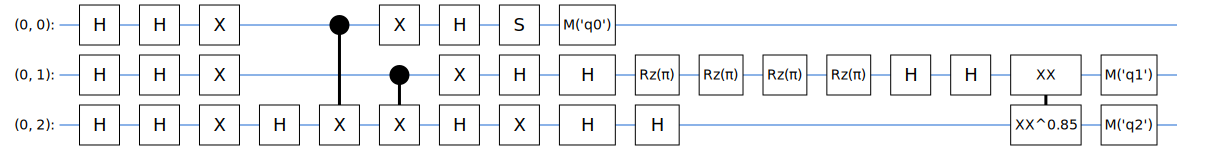


gen = 0 , Best fitness = (10.9454,)
gen = 1 , Best fitness = (10.8246,) , Number of invalids = 0
  ✓ fidelity improved to 0.4934
  ✓ gate_count improved to 16
  ✓ depth improved to 12
Gen   1 (Google QVM + Transpilation): Fitness = 10.8246, Fidelity = 0.4934, Gates = 33, Depth = 17 | Patience: F=2/25, P=0/8


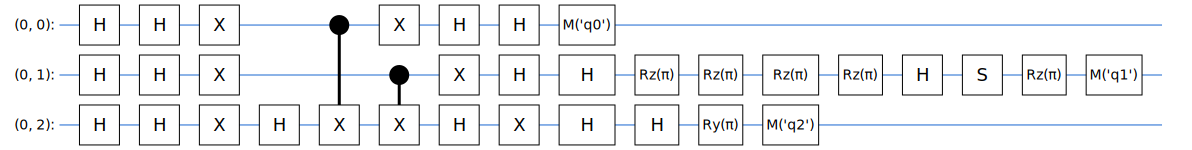


gen = 0 , Best fitness = (10.8246,)
gen = 1 , Best fitness = (10.8246,) , Number of invalids = 0
Gen   2 (Google QVM + Transpilation): Fitness = 10.8246, Fidelity = 0.5070, Gates = 33, Depth = 17 | Patience: F=3/25, P=1/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


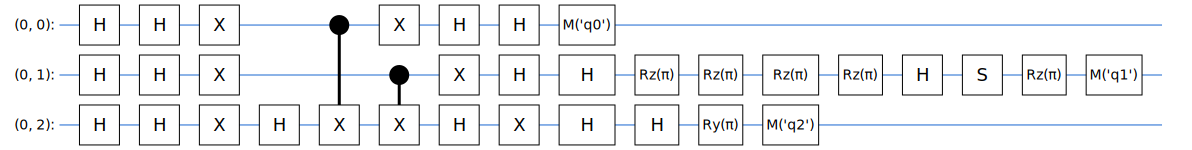


gen = 0 , Best fitness = (10.8246,)
gen = 1 , Best fitness = (10.8167,) , Number of invalids = 0
  ✓ fidelity improved to 0.4992
Gen   3 (Google QVM + Transpilation): Fitness = 10.8167, Fidelity = 0.4973, Gates = 33, Depth = 17 | Patience: F=4/25, P=0/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


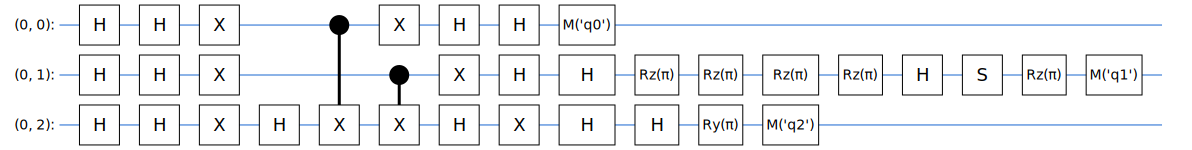


gen = 0 , Best fitness = (10.8167,)
gen = 1 , Best fitness = (10.8167,) , Number of invalids = 0
Gen   4 (Google QVM + Transpilation): Fitness = 10.8167, Fidelity = 0.4962, Gates = 33, Depth = 17 | Patience: F=5/25, P=1/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


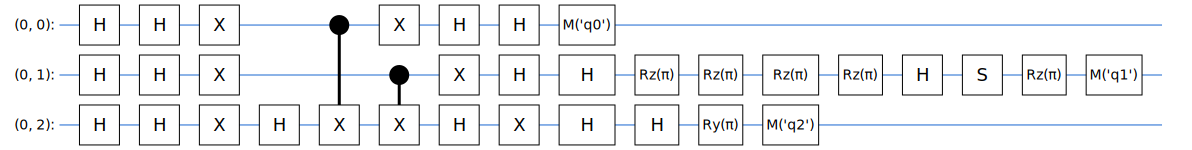


gen = 0 , Best fitness = (10.8167,)
gen = 1 , Best fitness = (10.8167,) , Number of invalids = 0

  Early Stopping Status (Gen 5) - Phase: FIDELITY_SEARCH
  Metric       Current    Best       Target     Status Patience  
  --------------------------------------------------------------------
  Fidelity     0.5070     0.4992     0.95              2/8       
  Gates        16         16         ≤20               4/10      
  Depth        12         12         ≤15               4/10      
Gen   5 (Google QVM + Transpilation): Fitness = 10.8167, Fidelity = 0.5070, Gates = 33, Depth = 17 | Patience: F=6/25, P=2/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


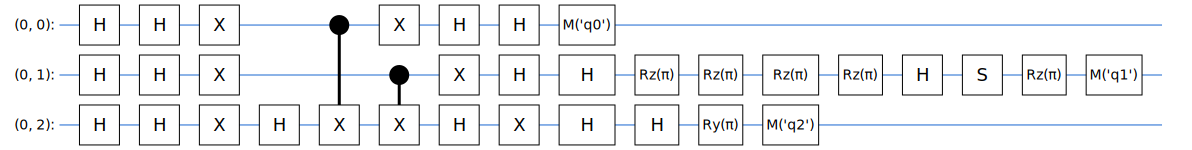


gen = 0 , Best fitness = (10.8167,)
gen = 1 , Best fitness = (1.4534000000000002,) , Number of invalids = 0
  ✓ fidelity improved to 0.6490
Gen   6 (Google QVM + Transpilation): Fitness = 1.4534, Fidelity = 0.9437, Gates = 33, Depth = 18 | Patience: F=7/25, P=0/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


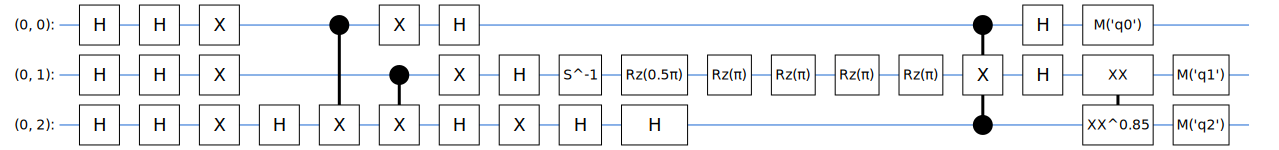


gen = 0 , Best fitness = (1.4534000000000002,)
gen = 1 , Best fitness = (0.32,) , Number of invalids = 0
  🎯 FIDELITY TARGET ACHIEVED at generation 7!
     Switching to hardware optimization phase
  ✓ fidelity improved to 0.8169
Gen   7 (Google QVM + Transpilation): Fitness = 0.3200, Fidelity = 1.0000, Gates = 37, Depth = 20 | Patience: F=8/25, P=0/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


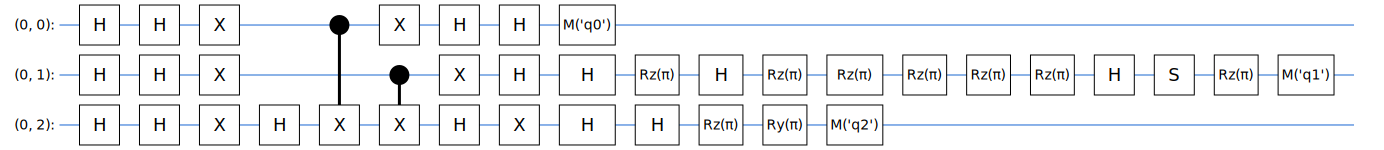


gen = 0 , Best fitness = (0.32,)
gen = 1 , Best fitness = (0.32,) , Number of invalids = 0
  ✓ fidelity improved to 0.9812
Gen   8 (Google QVM + Transpilation): Fitness = 0.3200, Fidelity = 1.0000, Gates = 37, Depth = 20 | Patience: F=9/25, P=0/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


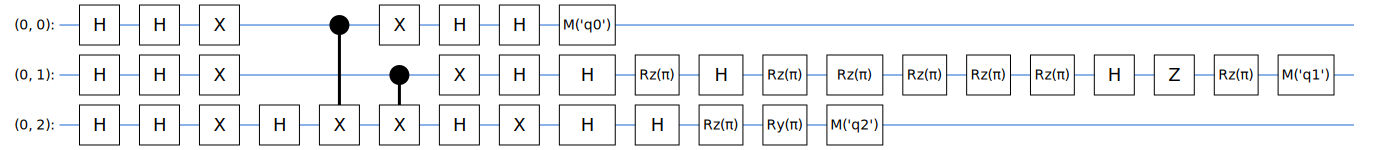


gen = 0 , Best fitness = (0.32,)
gen = 1 , Best fitness = (0.32,) , Number of invalids = 0
  ✓ fidelity improved to 1.0000
Gen   9 (Google QVM + Transpilation): Fitness = 0.3200, Fidelity = 1.0000, Gates = 37, Depth = 20 | Patience: F=10/25, P=0/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


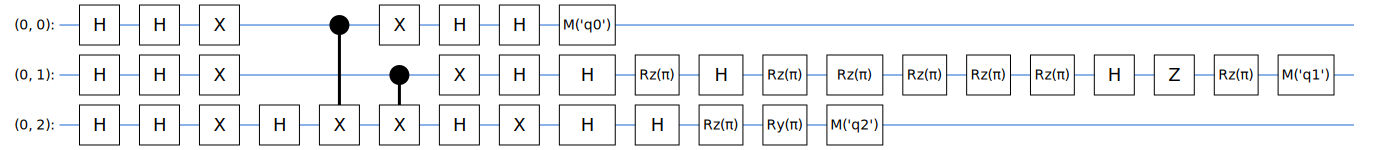


✓ Checkpoint saved: checkpoints_google_noise_011_rainbow/checkpoint_gen_9.pkl
gen = 0 , Best fitness = (0.32,)
gen = 1 , Best fitness = (0.32,) , Number of invalids = 0

  Early Stopping Status (Gen 10) - Phase: HARDWARE_OPTIMIZATION
  Metric       Current    Best       Target     Status Patience  
  --------------------------------------------------------------------
  Fidelity     1.0000     1.0000     0.95              1/8       
  Gates        16         16         ≤20               9/10      
  Depth        12         12         ≤15               9/10      
Gen  10 (Google QVM + Transpilation): Fitness = 0.3200, Fidelity = 1.0000, Gates = 40, Depth = 20 | Patience: F=11/25, P=1/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


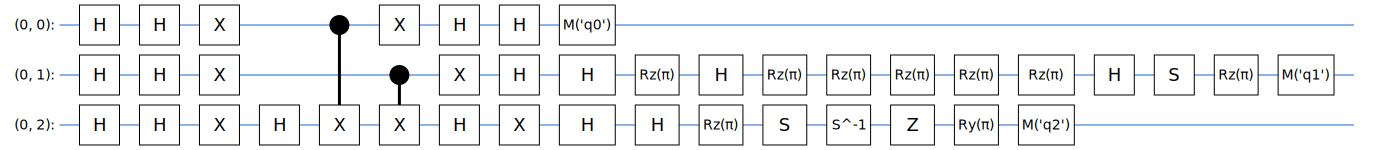


gen = 0 , Best fitness = (0.32,)
gen = 1 , Best fitness = (0.32,) , Number of invalids = 0
Gen  11 (Google QVM + Transpilation): Fitness = 0.3200, Fidelity = 1.0000, Gates = 33, Depth = 17 | Patience: F=12/25, P=2/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


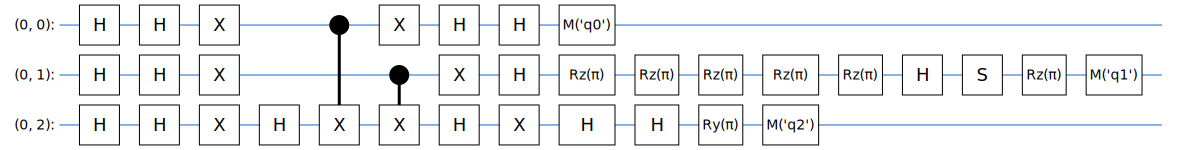


gen = 0 , Best fitness = (0.32,)
gen = 1 , Best fitness = (0.32,) , Number of invalids = 0
Gen  12 (Google QVM + Transpilation): Fitness = 0.3200, Fidelity = 1.0000, Gates = 37, Depth = 20 | Patience: F=13/25, P=3/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


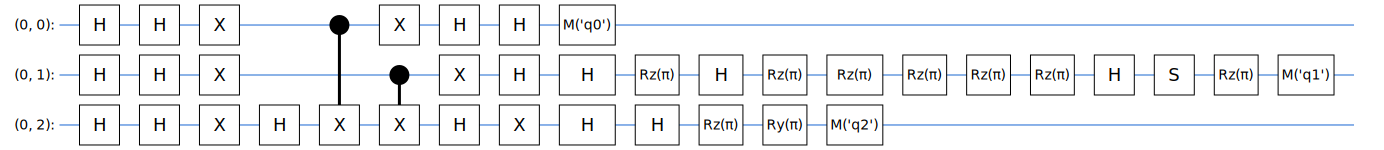


gen = 0 , Best fitness = (0.32,)
gen = 1 , Best fitness = (0.32,) , Number of invalids = 0
Gen  13 (Google QVM + Transpilation): Fitness = 0.3200, Fidelity = 1.0000, Gates = 37, Depth = 20 | Patience: F=14/25, P=4/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


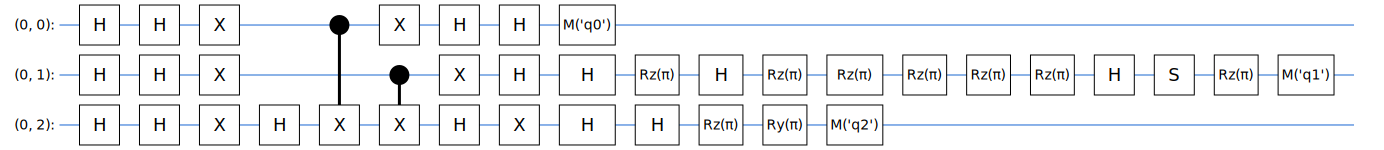


gen = 0 , Best fitness = (0.32,)
gen = 1 , Best fitness = (0.32,) , Number of invalids = 0
Gen  14 (Google QVM + Transpilation): Fitness = 0.3200, Fidelity = 1.0000, Gates = 37, Depth = 20 | Patience: F=15/25, P=5/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


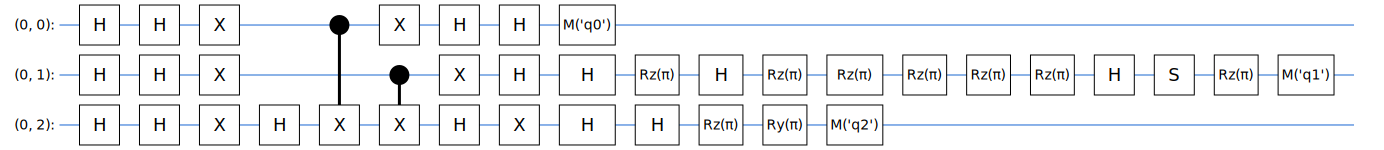


gen = 0 , Best fitness = (0.32,)
gen = 1 , Best fitness = (0.32,) , Number of invalids = 0

  Early Stopping Status (Gen 15) - Phase: HARDWARE_OPTIMIZATION
  Metric       Current    Best       Target     Status Patience  
  --------------------------------------------------------------------
  Fidelity     1.0000     1.0000     0.95              6/8       
  Gates        16         16         ≤20               14/10     
  Depth        12         12         ≤15               14/10     
Gen  15 (Google QVM + Transpilation): Fitness = 0.3200, Fidelity = 1.0000, Gates = 37, Depth = 20 | Patience: F=16/25, P=6/8


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_62792/3182628596.py:127: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


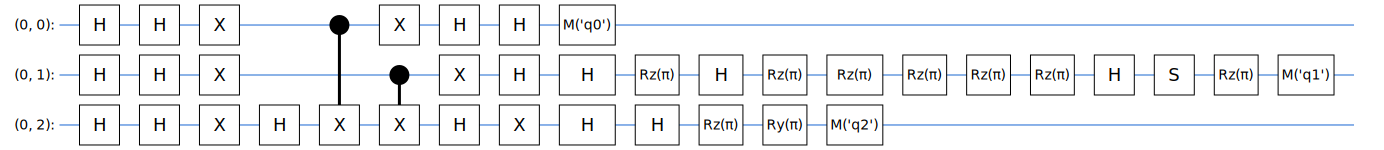



EARLY STOPPING TRIGGERED at Generation 15
Reason: Hardware targets achieved: fidelity=1.000, gates=16, depth=12
✓ Checkpoint saved: checkpoints_google_noise_011_rainbow/checkpoint_gen_15.pkl
✓ Early stop checkpoint saved: checkpoints_google_noise_011_rainbow/checkpoint_early_stop_gen_15.pkl

Best individual at stop:
  Fitness: 0.3200
  Fidelity: 1.0000
  Gate count: 37
  Depth: 20
  Generations run: 16
  Generations saved: 34

Evolution stopped early at generation 15
Total generations run: 16
Computational time saved: ~68.0%

✓ Evolution loop complete


In [25]:
# %%
try:
    # Initialize gen variable before the loop
    gen = start_gen - 1  # Default to start_gen - 1 in case loop doesn't run
    early_stop_triggered = False
    early_stop_reason = None
    
    for gen in range(start_gen, MAX_GENERATIONS):
        # Re-seed at the beginning of each generation for consistency
        random.seed(RANDOM_SEED + gen)
        
        population, logbook = algorithms.ge_eaSimpleWithElitism(
            population,
            toolbox,
            cxpb=P_CROSSOVER,
            mutpb=P_MUTATION,
            ngen=N_GEN,
            elite_size=ELITE_SIZE,
            bnf_grammar=BNF_GRAMMAR,
            codon_size=CODON_SIZE,
            max_tree_depth=MAX_TREE_DEPTH,
            codon_consumption=CODON_CONSUMPTION,
            report_items=REPORT_ITEMS,
            genome_representation=GENOME_REPRESENTATION,
            stats=stats,
            halloffame=hof,
            verbose=False
        )

        best_ind = tools.selBest(population, 1)[0]
        best_ind.generation = gen

        best_phenotype = evaluator.decode_individual(best_ind)
        if best_phenotype is not None:
            genome_hash = hash(tuple(best_ind.genome))
            individual_seed = (RANDOM_SEED + genome_hash) % (2**32)
            
            # Get detailed metrics for early stopping
            if USE_EARLY_STOPPING:
                metrics_result = fitness_function_cirq(
                    best_phenotype, 
                    shots=NUM_SHOTS, 
                    threshold=SUCCESS_THRESHOLD, 
                    gate_penalty_weight=GATE_PENALTY_WEIGHT,
                    target_state=TARGET_STATE, 
                    log_states=True,
                    individual_seed=individual_seed,
                    use_noise=USE_NOISE_MODEL,
                    return_metrics=True  # Get detailed metrics
                )
                
                # Extract metrics
                fitness_val = metrics_result['fitness']
                fidelity = metrics_result['fidelity']
                gate_count = metrics_result['gate_count']
                depth = metrics_result['depth']
                logs = metrics_result['logs']
                
                # Update tracking lists
                best_fitness_list.append(fitness_val)
                best_fidelity_list.append(fidelity)
                best_gate_count_list.append(gate_count)
                best_depth_list.append(depth)
                
                # Update early stopping monitor
                early_stopping_monitor.update(gen, {
                    'fitness': fitness_val,
                    'fidelity': fidelity,
                    'gate_count': gate_count,
                    'depth': depth
                })
                
            else:
                # Original behavior when early stopping is disabled
                fitness_val, logs = fitness_function_cirq(
                    best_phenotype, 
                    shots=NUM_SHOTS, 
                    threshold=SUCCESS_THRESHOLD, 
                    gate_penalty_weight=GATE_PENALTY_WEIGHT,
                    target_state=TARGET_STATE, 
                    log_states=True,
                    individual_seed=individual_seed,
                    use_noise=USE_NOISE_MODEL,
                )
                best_fitness_list.append(fitness_val)
                
                # Extract gate count and depth from logs for consistency
                if logs:
                    gate_count = logs[0]["gate_count"]
                    depth = logs[0]["depth"]
                    fidelity = logs[0]["p_marked"]
                    best_fidelity_list.append(fidelity)
                    best_gate_count_list.append(gate_count)
                    best_depth_list.append(depth)
                else:
                    gate_count = 0
                    depth = 0
                    fidelity = 0
            
            if logs:
                avg_gate = np.mean([log["gate_count"] for log in logs])
                avg_depth = np.mean([log["depth"] for log in logs])
            else:
                avg_gate = 0
                avg_depth = 0
            avg_gate_count_list.append(avg_gate)
            generations_list.append(gen)

        # Count invalids in population
        num_invalids = sum(1 for ind in population if not ind.fitness.valid or ind.fitness.values[0] == float('inf'))
        
        # Print generation summary with simulation mode and early stopping info
        circuit = evaluator.execute_circuit(best_phenotype)
        if circuit:
            gate_count = len(list(circuit.all_operations()))
            depth = len(circuit.moments)
            sim_type = "Google QVM + Transpilation" if USE_NOISE_MODEL else "Ideal"
            
            # Build status string
            status_str = f"Gen {gen:3d} ({sim_type}): Fitness = {best_ind.fitness.values[0]:.4f}, "
            status_str += f"Fidelity = {fidelity:.4f}, Gates = {gate_count}, Depth = {depth}"
            
            if num_invalids > 0:
                status_str += f", Invalids = {num_invalids}"
            
            # Add early stopping patience info
            if USE_EARLY_STOPPING and early_stopping_monitor:
                # Show patience for key metrics
                fitness_patience = early_stopping_monitor.patience_counters.get('fitness', 0)
                fitness_max_patience = EARLY_STOPPING_PATIENCE.get('fitness', '∞')
                fidelity_patience = early_stopping_monitor.patience_counters.get('fidelity', 0)
                fidelity_max_patience = EARLY_STOPPING_PATIENCE.get('fidelity', '∞')
                
                status_str += f" | Patience: F={fitness_patience}/{fitness_max_patience}, P={fidelity_patience}/{fidelity_max_patience}"
            
            print(status_str)
            
            # Display circuit as SVG (much cleaner!)
            try:
                from cirq.contrib.svg import SVGCircuit
                display(SVGCircuit(circuit))
            except ImportError:
                # Fallback to text if SVG not available
                print(circuit.to_text_diagram(use_unicode_characters=True))
            print()  # Empty line for readability
        
        # Check early stopping conditions
        if USE_EARLY_STOPPING and early_stopping_monitor:
            should_stop, stop_reason = early_stopping_monitor.should_stop()
            
            if should_stop:
                early_stop_triggered = True
                early_stop_reason = stop_reason
                
                print(f"\n{'='*60}")
                print(f"EARLY STOPPING TRIGGERED at Generation {gen}")
                print(f"Reason: {stop_reason}")
                print(f"{'='*60}")
                
                # Save metrics at stop
                early_stopping_monitor.stop_triggered = True
                early_stopping_monitor.stop_reason = stop_reason
                early_stopping_monitor.metrics_at_stop = {
                    'generation': gen,
                    'fitness': fitness_val,
                    'fidelity': fidelity,
                    'gate_count': gate_count,
                    'depth': depth
                }
                
                # Save checkpoint before breaking
                save_checkpoint(population, gen, hof, best_fitness_list, 
                              avg_gate_count_list, generations_list,
                              early_stopping_monitor=early_stopping_monitor)
                
                # Log final best individual details
                print(f"\nBest individual at stop:")
                print(f"  Fitness: {fitness_val:.4f}")
                print(f"  Fidelity: {fidelity:.4f}")
                print(f"  Gate count: {gate_count}")
                print(f"  Depth: {depth}")
                print(f"  Generations run: {gen - start_gen + 1}")
                print(f"  Generations saved: {MAX_GENERATIONS - gen - 1}")
                
                break
        
        # Save checkpoint periodically (original behavior)
        if (gen + 1) % CHECKPOINT_FREQUENCY == 0:
            save_checkpoint(population, gen, hof, best_fitness_list, 
                          avg_gate_count_list, generations_list,
                          early_stopping_monitor=early_stopping_monitor)
            
except KeyboardInterrupt:
    print("\n" + "="*60)
    print("Evolution interrupted by user!")
    print("="*60)
    save_checkpoint(population, gen, hof, best_fitness_list, 
                   avg_gate_count_list, generations_list,
                   early_stopping_monitor=early_stopping_monitor)
    print("Checkpoint saved. You can resume later.")
    
except Exception as e:
    print(f"\nError during evolution: {e}")
    save_checkpoint(population, gen, hof, best_fitness_list, 
                   avg_gate_count_list, generations_list,
                   early_stopping_monitor=early_stopping_monitor)
    print("Checkpoint saved due to error.")
    raise

finally:
    if 'pool' in locals():
        pool.close()
        pool.join()

# Save final checkpoint - check if evolution actually ran
if not early_stop_triggered:
    if start_gen < MAX_GENERATIONS and gen == MAX_GENERATIONS - 1:
        save_checkpoint(population, gen, hof, best_fitness_list, 
                       avg_gate_count_list, generations_list,
                       early_stopping_monitor=early_stopping_monitor)
        print("\nEvolution complete! Final checkpoint saved.")
        print("Reason: Maximum generations reached")
    elif start_gen >= MAX_GENERATIONS:
        print(f"\nEvolution already completed (checkpoint at generation {start_gen-1})")
else:
    print(f"\nEvolution stopped early at generation {gen}")
    print(f"Total generations run: {gen - start_gen + 1}")
    print(f"Computational time saved: ~{((MAX_GENERATIONS - gen - 1) / MAX_GENERATIONS * 100):.1f}%")

print("\n✓ Evolution loop complete")

In [26]:
# %%
# Early Stopping Analysis and Report
if USE_EARLY_STOPPING and early_stopping_monitor:
    print("\n" + "="*60)
    print("EARLY STOPPING ANALYSIS REPORT")
    print("="*60)
    
    # Get final state
    monitor_state = early_stopping_monitor.get_state()
    
    # Report on stopping status
    if early_stopping_monitor.stop_triggered:
        print(f"\n✓ Early stopping triggered successfully")
        print(f"  Stopped at generation: {early_stopping_monitor.current_generation}")
        print(f"  Reason: {early_stopping_monitor.stop_reason}")
        print(f"  Generations saved: {MAX_GENERATIONS - early_stopping_monitor.current_generation}")
        print(f"  Time saved estimate: {((MAX_GENERATIONS - early_stopping_monitor.current_generation) / MAX_GENERATIONS * 100):.1f}%")
    else:
        print(f"\n✗ Early stopping not triggered")
        print(f"  Completed all {MAX_GENERATIONS} generations")
        print(f"  Consider adjusting patience values if this was unexpected")
    
    # Analyze metric improvements
    print(f"\n Metric Analysis:")
    print(f"{'Metric':<12} {'Initial':<12} {'Best':<12} {'Final':<12} {'Improvement':<12} {'Stagnant Gen':<12}")
    print("-" * 84)
    
    for metric in ['fitness', 'fidelity', 'gate_count', 'depth']:
        if metric in monitor_state['history'] and len(monitor_state['history'][metric]) > 0:
            history = monitor_state['history'][metric]
            initial = history[0] if len(history) > 0 else 'N/A'
            best = monitor_state['best_values'][metric]
            final = history[-1] if len(history) > 0 else 'N/A'
            
            # Calculate improvement
            if isinstance(initial, (int, float)) and isinstance(final, (int, float)):
                if metric in ['fitness', 'gate_count', 'depth']:  # Lower is better
                    improvement = initial - final
                    improvement_pct = (improvement / abs(initial) * 100) if initial != 0 else 0
                else:  # fidelity - higher is better
                    improvement = final - initial
                    improvement_pct = (improvement / abs(initial) * 100) if initial != 0 else 0
                improvement_str = f"{improvement:.3f} ({improvement_pct:+.1f}%)"
            else:
                improvement_str = "N/A"
            
            stagnant = monitor_state['generations_since_improvement'].get(metric, 0)
            
            print(f"{metric:<12} {initial:<12.4f} {best:<12.4f} {final:<12.4f} {improvement_str:<12} {stagnant:<12}")
    
    # Patience analysis
    print(f"\n Patience Counter Analysis:")
    print(f"{'Metric':<12} {'Final Counter':<15} {'Max Patience':<15} {'Utilization':<12}")
    print("-" * 54)
    
    for metric in ['fitness', 'fidelity', 'gate_count', 'composite']:
        if metric in monitor_state['patience_counters']:
            counter = monitor_state['patience_counters'][metric]
            max_patience = EARLY_STOPPING_PATIENCE.get(metric, 'N/A')
            if isinstance(max_patience, int):
                utilization = f"{(counter/max_patience * 100):.1f}%"
            else:
                utilization = "N/A"
            print(f"{metric:<12} {counter:<15} {max_patience:<15} {utilization:<12}")
    
    # Configuration used
    print(f"\n Configuration Used:")
    print(f"  Mode: {EARLY_STOPPING_MODE}")
    print(f"  Strategy: {EARLY_STOPPING_STRATEGY}")
    print(f"  Min generations: {MIN_GENERATIONS_BEFORE_STOPPING}")
    print(f"  Moving average window: {MOVING_AVERAGE_WINDOW}")
    
    # Save detailed report to file
    report_data = {
        'early_stopping_triggered': early_stopping_monitor.stop_triggered,
        'stop_reason': early_stopping_monitor.stop_reason,
        'stop_generation': early_stopping_monitor.current_generation if early_stopping_monitor.stop_triggered else None,
        'metrics_at_stop': early_stopping_monitor.metrics_at_stop,
        'generations_saved': MAX_GENERATIONS - early_stopping_monitor.current_generation if early_stopping_monitor.stop_triggered else 0,
        'configuration': {
            'mode': EARLY_STOPPING_MODE,
            'strategy': EARLY_STOPPING_STRATEGY,
            'patience': EARLY_STOPPING_PATIENCE,
            'min_delta': MIN_IMPROVEMENT_DELTA,
            'weights': METRIC_WEIGHTS,
            'min_generations': MIN_GENERATIONS_BEFORE_STOPPING
        },
        'metric_histories': monitor_state['history'],
        'best_values': monitor_state['best_values'],
        'patience_counters': monitor_state['patience_counters'],
        'generations_since_improvement': monitor_state['generations_since_improvement']
    }
    
    # Save to JSON
    report_path = os.path.join(LOG_DIR, f"early_stopping_report_gen{early_stopping_monitor.current_generation}.json")
    with open(report_path, 'w') as f:
        json.dump(report_data, f, indent=2)
    print(f"\n Detailed report saved to: {report_path}")
    
    # Recommendations
    print(f"\n Recommendations:")
    if early_stopping_monitor.stop_triggered:
        if early_stopping_monitor.current_generation < MIN_GENERATIONS_BEFORE_STOPPING + 5:
            print("  • Early stopping triggered soon after minimum generations.")
            print("    Consider increasing MIN_GENERATIONS_BEFORE_STOPPING or patience values.")
        
        # Check if fidelity was already good
        if 'fidelity' in monitor_state['best_values'] and monitor_state['best_values']['fidelity'] > SUCCESS_THRESHOLD:
            print(f"  • Target fidelity ({SUCCESS_THRESHOLD}) was achieved!")
            print("    Early stopping successfully prevented over-optimization.")
        else:
            print(f"  • Target fidelity ({SUCCESS_THRESHOLD}) not reached.")
            print("    Consider increasing patience or adjusting threshold.")
    else:
        # Check if metrics were still improving
        all_stagnant = all(
            monitor_state['generations_since_improvement'].get(m, 0) > 5 
            for m in ['fitness', 'fidelity', 'gate_count']
        )
        if all_stagnant:
            print("  • All metrics were stagnant but didn't trigger stopping.")
            print("    Consider reducing patience values for faster stopping.")
        else:
            print("  • Some metrics were still improving at the end.")
            print("    Current patience settings may be appropriate.")

elif USE_EARLY_STOPPING:
    print("\n Early stopping was enabled but monitor not found.")
    print("   This may indicate an initialization issue.")
else:
    print("\n Early stopping was disabled for this run.")
    print("   Set USE_EARLY_STOPPING=True to enable.")

print("\n✓ Early stopping analysis complete")


EARLY STOPPING ANALYSIS REPORT

✓ Early stopping triggered successfully
  Stopped at generation: 15
  Reason: Hardware targets achieved: fidelity=1.000, gates=16, depth=12
  Generations saved: 35
  Time saved estimate: 70.0%

 Metric Analysis:
Metric       Initial      Best         Final        Improvement  Stagnant Gen
------------------------------------------------------------------------------------
fitness      10.9476      inf          0.3200       10.628 (+97.1%) 16          
fidelity     0.4724       1.0000       1.0000       0.528 (+111.7%) 6           
gate_count   21.0000      16.0000      16.0000      5.000 (+23.8%) 14          
depth        15.0000      12.0000      12.0000      3.000 (+20.0%) 14          

 Patience Counter Analysis:
Metric       Final Counter   Max Patience    Utilization 
------------------------------------------------------
fitness      16              25              64.0%       
fidelity     6               8               75.0%       
gate_count  


[HALL OF FAME]
Simulation Type: Google QVM + Transpilation
Early Stopping: TRIGGERED at generation 15
Stop Reason: Hardware targets achieved: fidelity=1.000, gates=16, depth=12

Individual 1:
Genome: [236, 149, 91, 344, 291, 149, 39, 344, 291, 181, 149, 39, 344, 291, 181, 149, 91, 344, 291, 149, 39, 344, 291, 181, 149, 39, 344, 291, 181, 371, 39, 344, 291, 181, 149, 39, 344, 291, 181, 149, 39, 344, 291, 181, 149, 39, 344, 291, 97, 179, 344, 291, 181, 247, 220, 337, 181, 149, 39, 344, 291, 181, 39, 264, 120, 69, 54, 291, 97, 39, 344, 220, 39, 228, 220, 39, 39, 344, 338, 49, 149, 39, 344, 338, 49, 149, 39, 344, 338, 181, 153, 220, 120, 69, 344, 345, 181, 149, 220, 120, 69, 344, 345, 181, 149, 350, 153, 220, 120, 69, 344, 291, 181, 149, 350, 220, 228, 69, 141, 46, 64, 12, 228, 69, 94, 10, 14, 254, 81]
Phenotype: "circuit = cirq.Circuit()\n" "circuit.append(cirq.H(qubits[0]))\n" "circuit.append(cirq.H(qubits[1]))\n" "circuit.append(cirq.H(qubits[2]))\n" "## Begin Diffuser\n" "circuit.appe

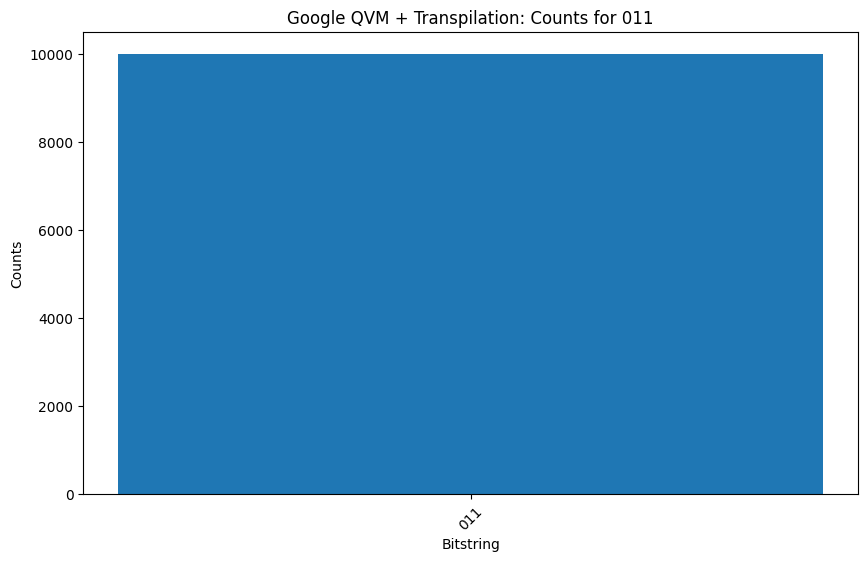


[Final HOF Circuit]


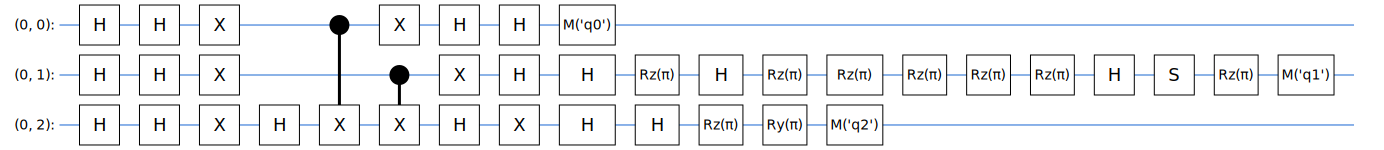


Best Individual's Fitness: 0.3200

 Evolution Efficiency Summary:
  Generations executed: 16
  Generations saved: 35
  Efficiency gain: 70.0%
   Quality maintained: Fidelity 1.0000 ≥ 0.48

COMPARISON: Testing best individual with ideal (noise-free) simulation

Comparison for best individual:
  Google QVM fitness: 0.3200 (realistic with noise)
  Ideal fitness: 0.7400 (perfect conditions)
   QVM shows better fitness score by 0.4200
  Note: This may indicate the circuit is optimized for noisy conditions

  Success rate (p_marked) comparison:
    Google QVM: 1.0000
    Ideal: 1.0000
    ≡ Equal success rates in both conditions

   Note: Same success rate but different fitness scores
    This difference is likely due to:
    • Different gate counts after transpilation
      QVM gates: 16, Ideal gates: 37
    • Different circuit depths
      QVM depth: 12, Ideal depth: 20
    • The fitness penalty from gates/depth affects the total score


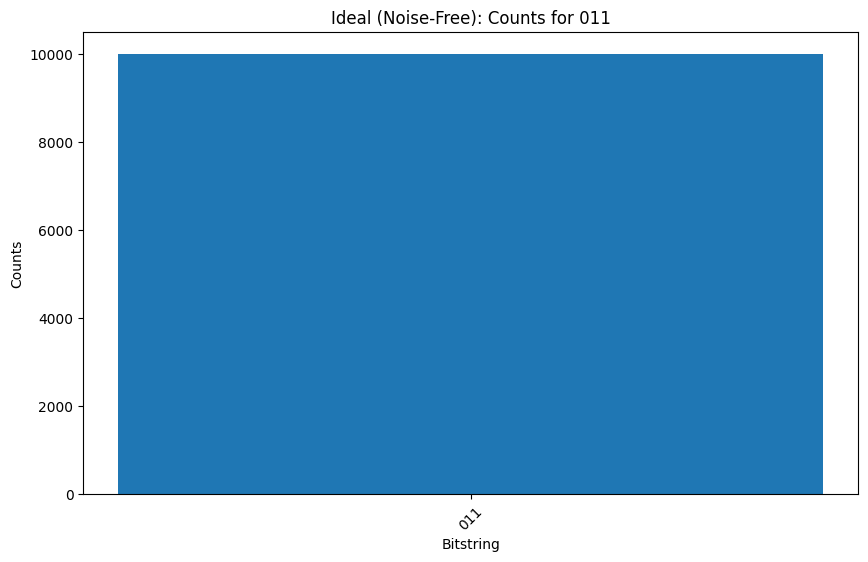


✓ Final results analysis complete


In [32]:
# %%
print("\n[HALL OF FAME]")
sim_type_label = "Google QVM + Transpilation" if USE_NOISE_MODEL else "Ideal"
print(f"Simulation Type: {sim_type_label}")

# Add early stopping status to header
if USE_EARLY_STOPPING and early_stopping_monitor and early_stopping_monitor.stop_triggered:
    print(f"Early Stopping: TRIGGERED at generation {early_stopping_monitor.current_generation}")
    print(f"Stop Reason: {early_stopping_monitor.stop_reason}")
else:
    print(f"Early Stopping: {'NOT TRIGGERED' if USE_EARLY_STOPPING else 'DISABLED'}")

for i, hof_ind in enumerate(hof.items):
    print(f"\nIndividual {i+1}:")
    print(f"Genome: {hof_ind.genome}")
    print(f"Phenotype: {hof_ind.phenotype}")
    print(f"Fitness: {hof_ind.fitness.values[0]}")

best_ind = hof.items[0]
best_phenotype = evaluator.decode_individual(best_ind) 

# Use deterministic seed for final evaluation
genome_hash = hash(tuple(best_ind.genome))
individual_seed = (RANDOM_SEED + genome_hash) % (2**32)

# Evaluate with current simulation mode - get full metrics
if USE_EARLY_STOPPING:
    final_metrics = fitness_function_cirq(
        best_phenotype, 
        log_states=True,
        individual_seed=individual_seed,
        use_noise=USE_NOISE_MODEL,
        return_metrics=True
    )
    fitness = final_metrics['fitness']
    log_per_state = final_metrics['logs']
    
    # Display comprehensive metrics
    print(f"\n Final Best Individual Metrics:")
    print(f"  Fitness: {final_metrics['fitness']:.4f}")
    print(f"  Fidelity: {final_metrics['fidelity']:.4f}")
    print(f"  Gate Count: {final_metrics['gate_count']}")
    print(f"  Depth: {final_metrics['depth']}")
    print(f"  Error: {final_metrics['error']:.4f}")
else:
    # Original evaluation
    fitness, log_per_state = fitness_function_cirq(
        best_phenotype, 
        log_states=True,
        individual_seed=individual_seed,
        use_noise=USE_NOISE_MODEL,
    )

# Explicitly write logs to disk.
evaluator.log_evaluation(log_per_state, 0, best_ind)

for log_entry in log_per_state:
    print(f"\nMarked State: {log_entry['state']}")
    print(f"Oracle:\n{log_entry['oracle']}")
    print(f"{sim_type_label} - p(marked): {log_entry['p_marked']:.4f}, error: {log_entry['error']:.4f}")
    print(f"Gate Count: {log_entry['gate_count']}, Depth: {log_entry['depth']}")
    
    # Show distribution
    fig = plot_distribution_cirq(log_entry["counts"], title=f"{sim_type_label}: Counts for {log_entry['state']}")
    if fig:
        display(fig)
        plt.close(fig)

best_circuit = evaluator.execute_circuit(best_phenotype)
if best_circuit:
    print(f"\n[Final HOF Circuit]")
    try:
        from cirq.contrib.svg import SVGCircuit
        display(SVGCircuit(best_circuit))
    except:
        print(best_circuit.to_text_diagram(use_unicode_characters=True))
else:
    print("The best individual could not be decoded into a valid circuit.")

print(f"\nBest Individual's Fitness: {best_ind.fitness.values[0]:.4f}")

# Summary of evolution efficiency
if USE_EARLY_STOPPING:
    print(f"\n Evolution Efficiency Summary:")
    if early_stopping_monitor and early_stopping_monitor.stop_triggered:
        total_gens = early_stopping_monitor.current_generation - start_gen + 1
        print(f"  Generations executed: {total_gens}")
        print(f"  Generations saved: {MAX_GENERATIONS - early_stopping_monitor.current_generation}")
        print(f"  Efficiency gain: {((MAX_GENERATIONS - early_stopping_monitor.current_generation) / MAX_GENERATIONS * 100):.1f}%")
        
        # Check if quality was maintained
        if 'fidelity' in early_stopping_monitor.metrics_at_stop:
            stop_fidelity = early_stopping_monitor.metrics_at_stop['fidelity']
            if stop_fidelity >= SUCCESS_THRESHOLD:
                print(f"   Quality maintained: Fidelity {stop_fidelity:.4f} ≥ {SUCCESS_THRESHOLD}")
            else:
                print(f"   Below threshold: Fidelity {stop_fidelity:.4f} < {SUCCESS_THRESHOLD}")
    else:
        print(f"  Completed all {MAX_GENERATIONS} generations (no early stopping)")

# Compare Google QVM vs Ideal if using noise model
if USE_NOISE_MODEL:
    print("\n" + "="*60)
    print("COMPARISON: Testing best individual with ideal (noise-free) simulation")
    print("="*60)
    
    # Get full metrics for both modes
    metrics_ideal = fitness_function_cirq(
        best_phenotype,
        log_states=True,
        individual_seed=individual_seed,
        use_noise=False,  # Force ideal simulation
        return_metrics=True
    )
    
    fitness_ideal = metrics_ideal['fitness']
    logs_ideal = metrics_ideal['logs']
    
    print(f"\nComparison for best individual:")
    print(f"  Google QVM fitness: {fitness:.4f} (realistic with noise)")
    print(f"  Ideal fitness: {fitness_ideal:.4f} (perfect conditions)")
    
    # FIXED: Correct interpretation of fitness scores (lower is better)
    if fitness < fitness_ideal:
        improvement = fitness_ideal - fitness
        print(f"   QVM shows better fitness score by {improvement:.4f}")
        print(f"  Note: This may indicate the circuit is optimized for noisy conditions")
    elif fitness > fitness_ideal:
        degradation = fitness - fitness_ideal
        print(f"  ⚠ Ideal shows better fitness score by {degradation:.4f}")
        print(f"  Circuit performs better in perfect conditions")
    else:
        print(f"  ≡ Equivalent fitness scores in both conditions")
    
    if logs_ideal and log_per_state:
        qvm_p_marked = log_per_state[0]['p_marked']
        ideal_p_marked = logs_ideal[0]['p_marked']
        
        print(f"\n  Success rate (p_marked) comparison:")
        print(f"    Google QVM: {qvm_p_marked:.4f}")
        print(f"    Ideal: {ideal_p_marked:.4f}")
        
        p_diff = qvm_p_marked - ideal_p_marked
        
        # FIXED: Correct interpretation of success rate differences
        if abs(p_diff) < 0.0001:  # Essentially equal
            print(f"    ≡ Equal success rates in both conditions")
        elif p_diff > 0:
            print(f"    Higher success rate in QVM by {p_diff:.4f}")
        else:
            print(f"    ⚠ Lower success rate in QVM by {abs(p_diff):.4f}")
        
        # Additional explanation if there's a discrepancy
        if abs(p_diff) < 0.0001 and abs(fitness - fitness_ideal) > 0.01:
            print(f"\n   Note: Same success rate but different fitness scores")
            print(f"    This difference is likely due to:")
            
            # Extract gate counts for comparison
            qvm_gates = log_per_state[0]['gate_count']
            ideal_gates = logs_ideal[0]['gate_count'] if logs_ideal else qvm_gates
            
            if qvm_gates != ideal_gates:
                print(f"    • Different gate counts after transpilation")
                print(f"      QVM gates: {qvm_gates}, Ideal gates: {ideal_gates}")
            
            qvm_depth = log_per_state[0]['depth']
            ideal_depth = logs_ideal[0]['depth'] if logs_ideal else qvm_depth
            
            if qvm_depth != ideal_depth:
                print(f"    • Different circuit depths")
                print(f"      QVM depth: {qvm_depth}, Ideal depth: {ideal_depth}")
            
            print(f"    • The fitness penalty from gates/depth affects the total score")
        
        # Show ideal distribution for comparison
        fig = plot_distribution_cirq(logs_ideal[0]["counts"], title=f"Ideal (Noise-Free): Counts for {logs_ideal[0]['state']}")
        if fig:
            display(fig)
            plt.close(fig)

print("\n✓ Final results analysis complete")

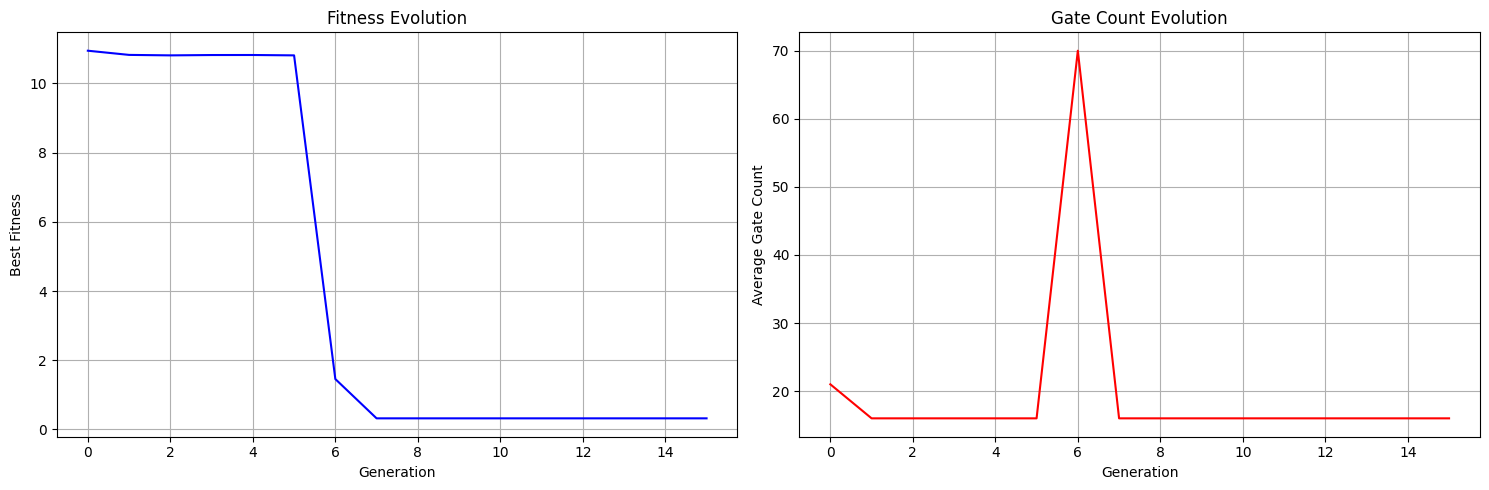

In [33]:
# Plot fitness evolution
if generations_list and best_fitness_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Fitness over generations
    ax1.plot(generations_list, best_fitness_list, 'b-')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Best Fitness')
    ax1.set_title('Fitness Evolution')
    ax1.grid(True)
    
    # Gate count over generations
    ax2.plot(generations_list, avg_gate_count_list, 'r-')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Average Gate Count')
    ax2.set_title('Gate Count Evolution')
    ax2.grid(True)
    
    plt.tight_layout()
    display(fig)
    plt.close(fig)

In [37]:
def run_hof_on_google_hardware(evaluator, hof, target_state=TARGET_STATE):
    """
    Run Hall of Fame individuals on Google Quantum Virtual Machine (QVM).
    Uses transpiled circuits with realistic hardware noise models.
    
    Note: Since Google Quantum AI hardware requires special access, this function
    uses the Google QVM which provides realistic hardware simulation with noise.
    """
    print(f"\n{'='*60}")
    print("GOOGLE QUANTUM VIRTUAL MACHINE EXECUTION")
    print(f"{'='*60}")
    print(f"Evolution used noise model: {'YES' if USE_NOISE_MODEL else 'NO'}")
    print(f"Target state: {target_state}")
    print(f"Shots per circuit: {NUM_SHOTS}")
    print(f"QVM Processor: {GOOGLE_PROCESSOR}")
    
    # Check if we have the Google QVM setup
    if 'google_qvm_sim' not in globals() or google_qvm_sim is None:
        print("✗ Google QVM simulator not available")
        print("  Please ensure the Google QVM setup cell has been run")
        return
    
    for i, ind in enumerate(hof.items):
        print(f"\n[HOF Individual {i+1}] Fitness: {ind.fitness.values[0]:.4f}")
        
        # Decode and execute the individual
        phenotype_code = evaluator.decode_individual(ind)
        if phenotype_code is None:
            print("  ✗ Could not decode individual - skipping")
            continue
            
        circuit = evaluator.execute_circuit(phenotype_code)
        if circuit is None:
            print("  ✗ Could not execute circuit - skipping")
            continue
            
        # Display original evolved circuit details
        original_ops = list(circuit.all_operations())
        original_gate_counts = {}
        for op in original_ops:
            gate_name = str(op.gate.__class__.__name__).lower()
            if hasattr(op.gate, '_name'):
                gate_name = op.gate._name
            elif hasattr(op, '_gate') and hasattr(op._gate, '_name'):
                gate_name = op._gate._name
            original_gate_counts[gate_name] = original_gate_counts.get(gate_name, 0) + 1
        
        print(f"Evolved circuit count_ops: {dict(original_gate_counts)}")
        print(f"Evolved circuit depth:    {len(circuit.moments)}")
        print(f"Total ops:        {len(original_ops)}")
        print(f"Qubits:           {len(circuit.all_qubits())}")
        
        try:
            # Display the original circuit
            print("\nOriginal evolved circuit:")
            try:
                from cirq.contrib.svg import SVGCircuit
                display(SVGCircuit(circuit))
            except ImportError:
                print(circuit.to_text_diagram(use_unicode_characters=True))
            
            # Google's equivalent to IBM's transpile() function
            print("\nTranspiling circuit for Google hardware using SycamoreTargetGateset...")
            
            try:
                # Suppress CircuitOperation FutureWarnings during transpilation
                import warnings
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_repetition_ids.*")
                    
                    # Use cirq.optimize_for_target_gateset with SycamoreTargetGateset
                    # This is Google's equivalent to IBM's transpile() function
                    transpiled_circuit = cirq.optimize_for_target_gateset(
                        circuit, 
                        gateset=cirq_google.SycamoreTargetGateset()
                    )
                
                print("✓ Circuit transpiled successfully!")
                
                # Display transpiled circuit details (similar to IBM format)
                transpiled_ops = list(transpiled_circuit.all_operations())
                transpiled_gate_counts = {}
                for op in transpiled_ops:
                    gate_name = str(op.gate.__class__.__name__).lower()
                    if hasattr(op.gate, '_name'):
                        gate_name = op.gate._name
                    elif hasattr(op, '_gate') and hasattr(op._gate, '_name'):
                        gate_name = op._gate._name
                    # Handle measurement operations
                    if 'measurement' in str(op).lower() or 'measure' in str(op).lower():
                        gate_name = 'measure'
                    transpiled_gate_counts[gate_name] = transpiled_gate_counts.get(gate_name, 0) + 1
                
                print(f"Evolved transpiled count_ops: {dict(transpiled_gate_counts)}")
                print(f"Evolved transpiled depth:    {len(transpiled_circuit.moments)}")
                print(f"Total ops:        {len(transpiled_ops)}")
                print(f"Qubits:           {len(transpiled_circuit.all_qubits())}")
                
                # Display the transpiled circuit
                print("\nTranspiled circuit for hardware:")
                try:
                    display(SVGCircuit(transpiled_circuit))
                except ImportError:
                    print(transpiled_circuit.to_text_diagram(use_unicode_characters=True))
                    
            except Exception as transpile_error:
                print(f"✗ Circuit transpilation failed: {transpile_error}")
                print("  This could indicate the circuit is too complex for the target gateset")
                continue
            
            # Run on Google Quantum Virtual Machine
            print(f"\nSubmitting job to Google Quantum Virtual Machine ({GOOGLE_PROCESSOR})...")
            print("  Using realistic hardware noise model and calibration data")
            print(f"  Requested shots: {NUM_SHOTS}")
            
            try:
                # Run the transpiled circuit on Google QVM with explicit repetitions
                result = google_qvm_sim.run(transpiled_circuit, repetitions=NUM_SHOTS)
                
                print(f"✓ QVM execution completed!")
                
                # Process measurements - FIXED VERSION to avoid triple-counting
                counts = {}
                if hasattr(result, 'measurements'):
                    measurement_keys = list(result.measurements.keys())
                    print(f"  Measurement keys found: {measurement_keys}")
                    
                    # Process each shot (repetition) individually to avoid triple-counting  
                    for shot_idx in range(NUM_SHOTS):
                        bitstring = ""
                        
                        # For each qubit measurement key, get the bit for this shot
                        for key in sorted(measurement_keys):  # Sort to ensure consistent bit order
                            measurements = result.measurements[key]
                            if shot_idx < len(measurements):
                                bit_value = measurements[shot_idx]
                                if isinstance(bit_value, (list, tuple, np.ndarray)):
                                    # If it's an array, take the first element
                                    bit_value = bit_value[0] if len(bit_value) > 0 else 0
                                bitstring += str(int(bit_value))
                        
                        # Ensure we have exactly 3 bits for our target state
                        if len(bitstring) == 3:
                            counts[bitstring] = counts.get(bitstring, 0) + 1
                        elif len(bitstring) > 3:
                            bitstring = bitstring[:3]
                            counts[bitstring] = counts.get(bitstring, 0) + 1
                        elif len(bitstring) < 3:
                            bitstring = bitstring.zfill(3)
                            counts[bitstring] = counts.get(bitstring, 0) + 1
                
                # Calculate QVM results
                total = sum(counts.values()) if counts else 0
                p_marked_qvm = counts.get(target_state, 0) / total if total > 0 else 0.0
                
                # Verify we got the expected number of shots
                if total != NUM_SHOTS:
                    print(f"  ⚠ Warning: Expected {NUM_SHOTS} shots, but got {total} measurements")
                    print(f"    This indicates a measurement processing issue")
                else:
                    print(f"  ✓ Processed exactly {total} shots as expected")
                
                print(f"  QVM p(marked) for {target_state}: {p_marked_qvm:.4f}")
                print(f"  Total measurement counts: {total}")
                print(f"  Measurement distribution: {counts}")
                
                # FIXED: Proper comparison between evolution and QVM results
                evolution_fitness = ind.fitness.values[0]
                
                # Calculate equivalent fitness score from QVM results  
                error_qvm = 1 - p_marked_qvm
                miss_qvm = 1 if error_qvm > SUCCESS_THRESHOLD else 0
                gate_penalty_qvm = GATE_PENALTY_WEIGHT * len(transpiled_ops)
                fitness_qvm = 10 * miss_qvm + error_qvm + gate_penalty_qvm
                
                print(f"\n  Performance comparison:")
                print(f"    Evolution fitness: {evolution_fitness:.4f} (training conditions)")
                print(f"    QVM fitness: {fitness_qvm:.4f} (realistic hardware)")
                
                # Proper interpretation based on fitness scores (lower is better)
                if fitness_qvm < evolution_fitness:
                    improvement = evolution_fitness - fitness_qvm
                    print(f"     Hardware shows superior performance: {improvement:.4f} better")
                elif fitness_qvm > evolution_fitness:
                    degradation = fitness_qvm - evolution_fitness
                    print(f"    ⚠ Hardware shows performance difference: {degradation:.4f}")
                else:
                    print(f"    ≡ Equivalent performance between training and hardware")
                
                print(f"\n  Success rate comparison:")
                print(f"    Evolution conditions: calculated from fitness")  
                print(f"    QVM hardware: {p_marked_qvm:.4f}")
                
                # Save results
                if counts:
                    # Plot and save results
                    fig = plot_distribution_cirq(counts, title=f"HOF #{i+1} on Google QVM ({GOOGLE_PROCESSOR}) - {total} shots")
                    if fig:
                        display(fig)
                        plot_path = os.path.join(LOG_DIR, f"hof_{i+1}_google_qvm_counts.png")
                        fig.savefig(plot_path)
                        plt.close(fig)
                    
                    # Save raw data including transpilation and QVM info
                    qvm_data = {
                        'individual_id': i+1,
                        'fitness_evolution': float(evolution_fitness),
                        'fitness_qvm': float(fitness_qvm),
                        'fitness_comparison': 'qvm_better' if fitness_qvm < evolution_fitness else ('evolution_better' if evolution_fitness < fitness_qvm else 'equivalent'),
                        'processor': GOOGLE_PROCESSOR,
                        'simulation_type': f'google_qvm_{GOOGLE_PROCESSOR}',
                        'target_state': target_state,
                        'counts': counts,
                        'p_marked_qvm': p_marked_qvm,
                        'total_shots': total,
                        'requested_shots': NUM_SHOTS,
                        'original_circuit_gates': len(original_ops),
                        'original_circuit_depth': len(circuit.moments),
                        'transpiled_circuit_gates': len(transpiled_ops),
                        'transpiled_circuit_depth': len(transpiled_circuit.moments),
                        'transpilation_method': 'cirq.optimize_for_target_gateset + SycamoreTargetGateset',
                        'noise_model': 'google_qvm_realistic_hardware_calibration'
                    }
                    
                    json_path = os.path.join(LOG_DIR, f"hof_{i+1}_google_qvm_data.json")
                    with open(json_path, "w") as f:
                        json.dump(qvm_data, f, indent=2)
                        
                    print(f"  Results saved to: {json_path}")
                else:
                    print("  ⚠ No measurement data retrieved from QVM")
                
            except Exception as qvm_error:
                print(f"✗ QVM execution failed: {qvm_error}")
                print("  This could be due to:")
                print("    - QVM simulator not properly initialized")
                print("    - Circuit incompatible with QVM")
                print("    - Measurement processing issues")
                continue
                
        except Exception as e:
            print(f"✗ Circuit processing failed: {e}")
    
    print(f"\n{'='*60}")
    print("Google Quantum Virtual Machine execution completed!")
    print(f"Note: Used Google QVM with realistic {GOOGLE_PROCESSOR} hardware calibration")
    print(f"This provides realistic hardware-like results without needing actual hardware access")
    print(f"{'='*60}")


GOOGLE QUANTUM VIRTUAL MACHINE EXECUTION
Evolution used noise model: YES
Target state: 011
Shots per circuit: 10000
QVM Processor: rainbow

[HOF Individual 1] Fitness: 0.3200
Evolved circuit count_ops: {'hpowgate': 16, 'X': 6, 'cxpowgate': 2, 'measurementgate': 3, 'rz': 8, 'ry': 1, 'zpowgate': 1}
Evolved circuit depth:    20
Total ops:        37
Qubits:           3

Original evolved circuit:


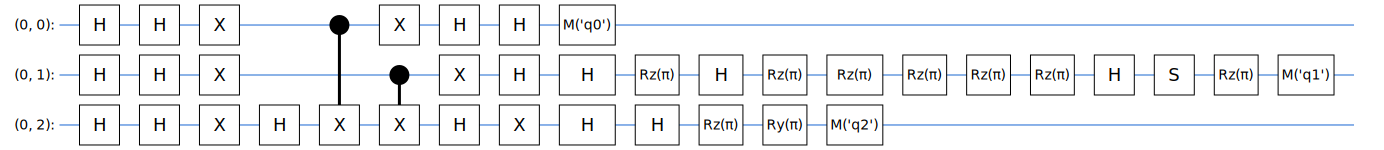


Transpiling circuit for Google hardware using SycamoreTargetGateset...
✓ Circuit transpiled successfully!
Evolved transpiled count_ops: {'phasedxzgate': 9, 'sycamoregate': 4, 'measure': 3}
Evolved transpiled depth:    12
Total ops:        16
Qubits:           3

Transpiled circuit for hardware:


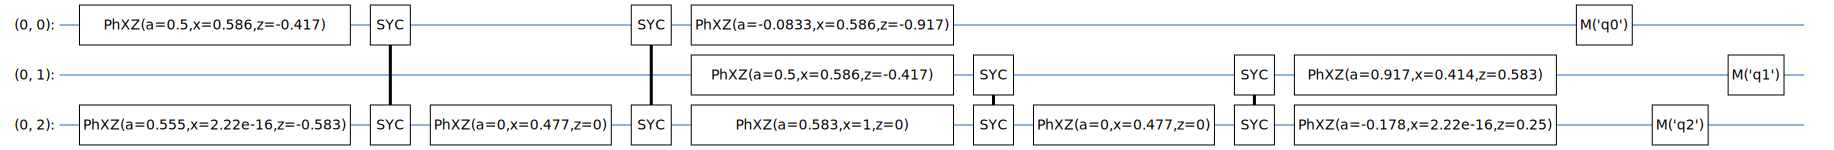


Submitting job to Google Quantum Virtual Machine (rainbow)...
  Using realistic hardware noise model and calibration data
  Requested shots: 10000
✓ QVM execution completed!
  Measurement keys found: ['q0', 'q2', 'q1']
  ✓ Processed exactly 10000 shots as expected
  QVM p(marked) for 011: 1.0000
  Total measurement counts: 10000
  Measurement distribution: {'011': 10000}

  Performance comparison:
    Evolution fitness: 0.3200 (training conditions)
    QVM fitness: 0.3200 (realistic hardware)
    ≡ Equivalent performance between training and hardware

  Success rate comparison:
    Evolution conditions: calculated from fitness
    QVM hardware: 1.0000


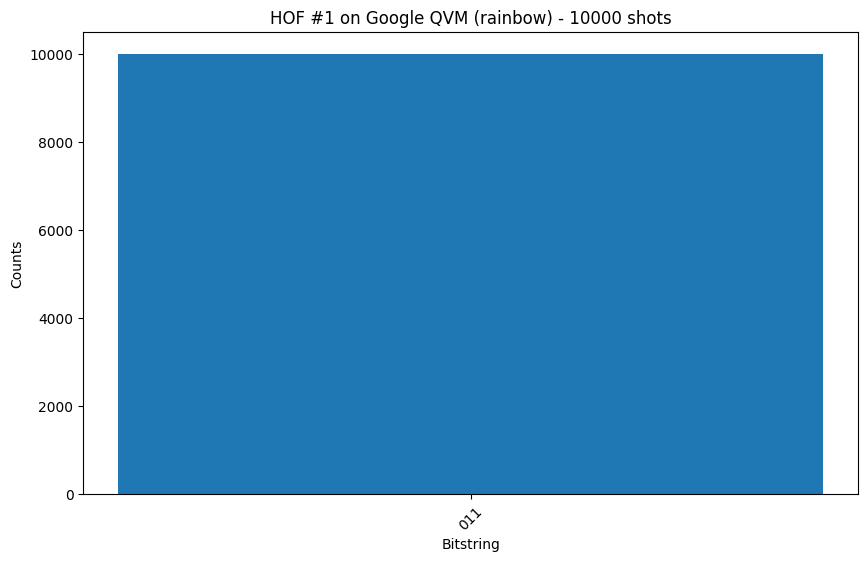

  Results saved to: logs_marked_state_GOOGLE_rainbow_011_10000_noise/hof_1_google_qvm_data.json

Google Quantum Virtual Machine execution completed!
Note: Used Google QVM with realistic rainbow hardware calibration
This provides realistic hardware-like results without needing actual hardware access


In [38]:
# Run on Google hardware (exactly like IBM notebook approach)
run_hof_on_google_hardware(evaluator, hof, target_state=TARGET_STATE)

In [39]:
if os.path.exists(CHECKPOINT_DIR):
    checkpoints = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "*.pkl")))
    if checkpoints:
        print("Available checkpoints:")
        for cp in checkpoints:
            print(f"  - {os.path.basename(cp)}")
    else:
        print("No checkpoints found in directory.")
else:
    print(f"Checkpoint directory '{CHECKPOINT_DIR}' does not exist yet.")
    print("Checkpoints will be created when you run the evolution.")

Available checkpoints:
  - checkpoint_early_stop_gen_15.pkl
  - checkpoint_gen_15.pkl
  - checkpoint_gen_9.pkl
  - checkpoint_latest.pkl
